## Domain-specific forecasting

This notebook is based on Andrej Karpathy's [Zero To Hero](https://karpathy.ai/zero-to-hero.html) video on GPT.

In [1]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import torch

# Settings
data_dir = "../data/"
output_file = "finance_master_dataset.parquet"

In [2]:
# Diagnostic check
def check_data_quality(data_dir):
    total_rows = 0
    zero_prices = 0
    negative_prices = 0
    
    subfolders = ['stocks', 'etfs']
    files_to_check = []
    for f in subfolders:
        p = os.path.join(data_dir, f)
        if os.path.exists(p):
            files_to_check.extend([os.path.join(p, file) for file in os.listdir(p)[:1000]])

    print(f"Checking sample of {len(files_to_check)} files...")
    for f in tqdm(files_to_check):
        df = pd.read_csv(f)
        price_cols = ['Open', 'High', 'Low', 'Close', 'Adj Close']
        
        for col in price_cols:
            if col in df.columns:
                total_rows += len(df)
                zero_prices += (df[col] == 0).sum()
                negative_prices += (df[col] < 0).sum()
                
    print(f"\n--- DATA QUALITY REPORT ---")
    print(f"Total rows scanned: {total_rows}")
    print(f"Zero values: {zero_prices} ({100*zero_prices/total_rows:.2f}%)")
    print(f"Negative values: {negative_prices} ({100*negative_prices/total_rows:.2f}%)")

check_data_quality(data_dir)

Checking sample of 2000 files...


100%|██████████| 2000/2000 [01:27<00:00, 22.74it/s]


--- DATA QUALITY REPORT ---
Total rows scanned: 29276020
Zero values: 132750 (0.45%)
Negative values: 2648 (0.01%)


In [4]:
def create_master_dataset():
    all_records = []
    subfolders = ['stocks', 'etfs']
    
    tasks = []
    for folder in subfolders:
        folder_path = os.path.join(data_dir, folder)
        if os.path.exists(folder_path):
            files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]
            for f in files:
                tasks.append((folder, f))
    
    if not tasks:
        print("No CSV files found.")
        return

    print(f"Building Master Dataset from {len(tasks)} files...")
    for folder, file in tqdm(tasks, desc="Consolidating market data"):
        try:
            ticker = file.replace('.csv', '')
            file_path = os.path.join(data_dir, folder, file)
            
            # Load data
            df = pd.read_csv(file_path)
            
            # 1. DATA CLEANING: Remove rows with zero or negative prices
            # This prevents "divide by zero" and "invalid value" warnings in log calculations
            price_cols = ['Open', 'High', 'Low', 'Close', 'Adj Close']
            for col in price_cols:
                if col in df.columns:
                    df = df[df[col] > 0]
            
            if len(df) < 2: continue

            df['Date'] = pd.to_datetime(df['Date'])
            df['ticker'] = ticker
            
            # 2. Log Transformations
            # Use a temporary variable for shifted price to ensure it's also > 0
            prev_adj_close = df['Adj Close'].shift(1)
            
            # Only calculate for rows where previous close is positive
            mask = (prev_adj_close > 0)
            
            df.loc[mask, 'o_gap'] = np.log(df['Open'] / prev_adj_close)
            df.loc[mask, 'h_range'] = np.log(df['High'] / df['Open'])
            df.loc[mask, 'l_range'] = np.log(df['Low'] / df['Open'])
            df.loc[mask, 'c_ret'] = np.log(df['Adj Close'] / df['Open'])
            
            # Drop the first row and any rows where log calculation failed
            df = df.dropna(subset=['o_gap', 'h_range', 'l_range', 'c_ret'])
            
            all_records.append(df)
            
        except Exception:
            continue

    if all_records:
        master_df = pd.concat(all_records).reset_index(drop=True)
        master_df.to_parquet(output_file)
        print(f"Success: Master Dataset saved as {output_file} ({len(master_df)} rows)")

if not os.path.exists(output_file):
    create_master_dataset()

Shape: (26947911, 12)
unique Tickers: 8047

--- Health Check ---
           Nulls  Infs
Adj Close      0   0.0
Close          0   0.0
Date           0   NaN
High           0   0.0
Low            0   0.0
Open           0   0.0
Volume         0   0.0
c_ret          0   0.0
h_range        0   0.0
l_range        0   0.0
o_gap          0   0.0
ticker         0   NaN

--- Feature Statistics ---
              o_gap       h_range       l_range         c_ret
count  2.694791e+07  2.694791e+07  2.694791e+07  2.694791e+07
mean   3.336165e-01  1.476886e-02 -1.554643e-02 -3.335461e-01
std    6.956978e-01  2.919235e-02  2.997132e-02  6.819208e-01
min   -4.419685e+01 -4.605170e+00 -1.214891e+01 -1.876545e+01
1%    -5.044715e-02  0.000000e+00 -1.201141e-01 -2.928379e+00
5%    -1.077209e-02  0.000000e+00 -5.798725e-02 -1.428310e+00
50%    1.063101e-01  6.907444e-03 -7.361969e-03 -1.072531e-01
95%    1.434365e+00  5.493375e-02  0.000000e+00  2.177090e-02
99%    2.958649e+00  1.177830e-01  0.000000e+00  7

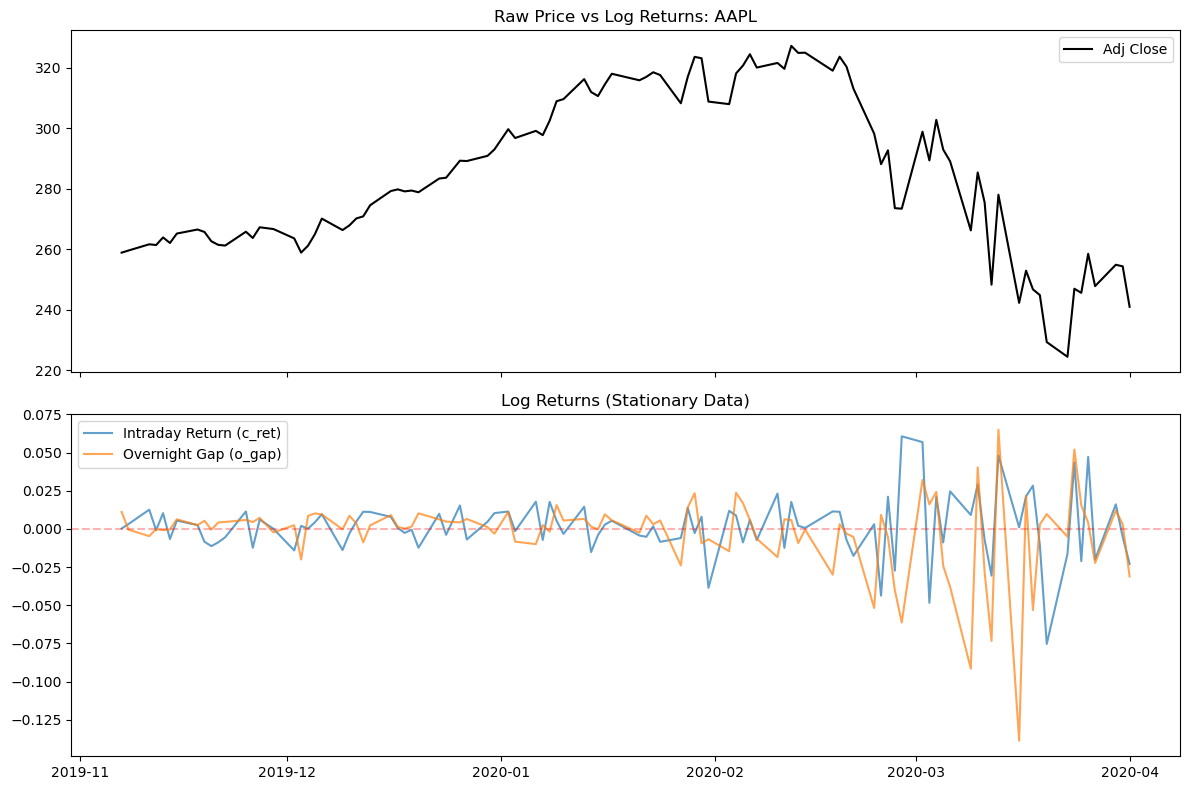

--- Raw Row Inspection for AAPL ---


,Date,Open,High,Low,Adj Close,o_gap,h_range,l_range,c_ret
63928,2020-03-19,247.389999,252.839996,242.610001,244.779999,0.002915,0.021791,-0.019511,-0.010606
63929,2020-03-20,247.179993,251.830002,228.000000,229.240005,0.009757,0.018637,-0.080771,-0.075347
63930,2020-03-23,228.080002,228.500000,212.610001,224.369995,-0.005073,0.001840,-0.070237,-0.016400
63931,2020-03-24,236.360001,247.690002,234.300003,246.880005,0.052060,0.046822,-0.008754,0.043546
63932,2020-03-25,250.750000,258.250000,244.300003,245.520004,0.015554,0.029472,-0.026059,-0.021078
63933,2020-03-26,246.520004,258.679993,246.360001,258.440002,0.004065,0.048149,-0.000649,0.047220
63934,2020-03-27,252.750000,255.869995,247.050003,247.740005,-0.022263,0.012269,-0.022810,-0.020021
63935,2020-03-30,250.740005,255.520004,249.399994,254.809998,0.012037,0.018884,-0.005359,0.016102
63936,2020-03-31,255.600006,262.489990,252.000000,254.289993,0.003096,0.026599,-0.014185,-0.005138
63937,2020-04-01,246.500000,248.720001,239.130005,240.910004,-0.031113,0.008966,-0.030355,-0.022939


In [8]:
# Load the master data
df = pd.read_parquet("finance_master_dataset.parquet")

print(f"Shape: {df.shape}")
print(f"unique Tickers: {df['ticker'].nunique()}")

# Check for problematic values
health_check = pd.DataFrame({
    "Nulls": df.isnull().sum(),
    "Infs": np.isinf(df.select_dtypes(include=np.number)).sum()
})
print("\n--- Health Check ---")
print(health_check)

# Statistical summary of the training features
training_features = ["o_gap", "h_range", "l_range", "c_ret"]
summary = df[training_features].describe(percentiles=[.01, .05, .5, .95, .99])
print("\n--- Feature Statistics ---")
print(summary)

# Validation logic
logic_errors = {
    "High < Low": (df["High"] < df["Low"]).sum(),
    "High < Open": (df["High"] < df["Open"]).sum(),
    "Low > Open": (df["Low"] > df["Open"]).sum(),
    "h_range < 0": (df["h_range"] < 0).sum(), # Should be impossible by ln(H/O) if H >= O
    "l_range > 0": (df["l_range"] > 0).sum()  # Should be impossible by ln(L/O) if L <= O
}

print("\n--- Logic Consistency Errors ---")
for error, count in logic_errors.items():
    print(f"{error}: {count}")

import matplotlib.pyplot as plt

# Pick a ticker to inspect (e.g., SPY or AAPL)
sample_ticker = "AAPL" # or df["ticker"].unique()[0]
sample_df = df[df["ticker"] == sample_ticker].sort_values("Date").tail(100)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Plot Raw Prices
ax1.plot(sample_df["Date"], sample_df["Adj Close"], label="Adj Close", color="black")
ax1.set_title(f"Raw Price vs Log Returns: {sample_ticker}")
ax1.legend()

# Plot Log Returns (Stationary)
ax2.plot(sample_df["Date"], sample_df["c_ret"], label="Intraday Return (c_ret)", alpha=0.7)
ax2.plot(sample_df["Date"], sample_df["o_gap"], label="Overnight Gap (o_gap)", alpha=0.7)
ax2.axhline(0, color="red", linestyle="--", alpha=0.3)
ax2.set_title("Log Returns (Stationary Data)")
ax2.legend()

plt.tight_layout()
plt.show()

# Select the most relevant columns for logical verification
cols_to_show = [
    'Date', 'Open', 'High', 'Low', 'Adj Close',  # Raw Inputs
    'o_gap', 'h_range', 'l_range', 'c_ret'      # Your "Words" for the Transformer
]

# Formatting to make it easy to read
print(f"--- Raw Row Inspection for {sample_ticker} ---")
display(sample_df[cols_to_show].tail(10))


In [21]:
# 1. Load Master Data
print("Loading Master Dataset...")
df = pd.read_parquet("finance_master_dataset.parquet")
df['Date'] = pd.to_datetime(df['Date'])

# --- NEW CLEANING STEP START ---
print(f"Original shape: {df.shape}")

# Drop rows where there was 0 volatility (High == Low)
# This removes holidays, data errors, and frozen/delisted stocks
# If High == Low, the stock didn't move, providing no signal for the Transformer
df = df[df['High'] > df['Low']]

# Optional: Drop rows where Volume is 0 (if you have the column)
if 'Volume' in df.columns:
    df = df[df['Volume'] > 0]

print(f"Cleaned shape: {df.shape}")
# --- NEW CLEANING STEP END ---

# --- CRITICAL THESIS STEP: TEMPORAL SPLIT ---
# We split by Date BEFORE creating the vocabulary to prevent look-ahead bias
cutoff_date = pd.Timestamp("2017-01-01")

print(f"Splitting data at {cutoff_date}...")
train_df = df[df['Date'] < cutoff_date].copy()
val_df = df[df['Date'] >= cutoff_date].copy()

print(f"Train Range: {train_df['Date'].min().date()} -> {train_df['Date'].max().date()}")
print(f"Val Range:   {val_df['Date'].min().date()} -> {val_df['Date'].max().date()}")

# 2. Calculate Vocabulary (Using ONLY Training Data)
training_features = ['o_gap', 'h_range', 'l_range', 'c_ret']
train_values = train_df[training_features].values.flatten()

# Filter outliers based on historical norms (1999-2016)
q_low, q_high = np.percentile(train_values, [1, 99])
filtered_values = train_values[(train_values > q_low) & (train_values < q_high)]

vocab_size = 500
_, bins = pd.qcut(filtered_values, vocab_size, retbins=True, labels=False, duplicates='drop')
actual_vocab_size = len(bins) - 1
sep_token = actual_vocab_size 

# 3. Save Bins for Analysis
np.save('bin_definitions.npy', bins)

# Helper for encoding
def stoi_func(val):
    idx = np.digitize([val], bins)[0] - 1
    return int(np.clip(idx, 0, actual_vocab_size - 1))

# 4. Tokenization Function (Reusable)
def tokenize_split(dataset_df, desc):
    all_tokens = []
    # Group by Ticker -> Sort by Date
    for ticker, group in tqdm(dataset_df.groupby('ticker'), desc=desc):
        group = group.sort_values('Date')
        
        # Flatten [O,H,L,C, O,H,L,C...]
        flat_values = group[training_features].values.flatten()
        
        # Convert to tokens
        encoded = [stoi_func(x) for x in flat_values]
        
        all_tokens.extend(encoded)
        all_tokens.append(sep_token) # End of Ticker
        
    return torch.tensor(all_tokens, dtype=torch.long)

# 5. Execute and Save Splits
train_data = tokenize_split(train_df, "Tokenizing Train (Past)")
val_data = tokenize_split(val_df, "Tokenizing Val (Future)")

torch.save(train_data, 'train.bin')
torch.save(val_data, 'val.bin')

print(f"\nSUCCESS!")
print(f"Train tokens: {len(train_data):,}")
print(f"Val tokens:   {len(val_data):,}")
print(f"Files saved: 'train.bin', 'val.bin', 'bin_definitions.npy'")

Loading Master Dataset...
Original shape: (26947911, 12)
Cleaned shape: (24466888, 12)
Splitting data at 2017-01-01 00:00:00...
Train Range: 1962-01-03 -> 2016-12-30
Val Range:   2017-01-03 -> 2020-04-01


Tokenizing Val (Future): 100%|██████████| 8044/8044 [08:43<00:00, 15.35it/s]



SUCCESS!
Train tokens: 76,101,558
Val tokens:   21,780,380
Files saved: 'train.bin', 'val.bin', 'bin_definitions.npy'


In [2]:
# 1. Load from disk
# Note: We use 'train.bin' which we just created in the cleaning step
data = torch.load('train.bin') 
bins = np.load('bin_definitions.npy')

# 2. Reconstruct the 'itos' dictionary from the bins
# (This is the part that was missing after the restart)
actual_vocab_size = len(bins) - 1
sep_token = actual_vocab_size 

# Value is the midpoint of the bin
itos = {i: (bins[i] + bins[i+1]) / 2 for i in range(actual_vocab_size)}
itos[sep_token] = 0.0 # Define the separator value

# 3. Look at the first 12 tokens (3 days of the first ticker)
print(f"First 12 tokens: {data[:12].tolist()}")

# 4. Decode them back to verify logic
decoded_values = [itos[i.item()] for i in data[:12]]
print(f"Decoded returns: {[f'{x:.4f}' for x in decoded_values]}")

First 12 tokens: [381, 234, 85, 55, 391, 363, 113, 81, 379, 333, 90, 55]
Decoded returns: ['0.1248', '0.0014', '-0.0743', '-0.2120', '0.1748', '0.0634', '-0.0310', '-0.0863', '0.1160', '0.0261', '-0.0618', '-0.2120']


In [3]:
# Load your specific finance tensors
train_data = torch.load('train.bin')
val_data = torch.load('val.bin')
vocab_size = 501 # 500 bins + 1 separator

In [4]:
block_size = 8
train_data[:block_size+1]

tensor([381, 234,  85,  55, 391, 363, 113,  81, 379])

In [5]:
# 1. Grab the chunk
x = train_data[:block_size]     # Inputs (First 8 tokens)
y = train_data[1:block_size+1]  # Targets (Next 8 tokens)

# 2. Print the learning steps
print(f"--- Visualizing the Autoregressive Task (Block Size: {block_size}) ---")
for t in range(block_size):
    context = x[:t+1]
    target = y[t]
    
    # Decode for readability (assuming 'itos' is loaded)
    context_str = [f"{itos[i.item()]:.2%}" if i.item() in itos else "SEP" for i in context]
    target_str = f"{itos[target.item()]:.2%}" if target.item() in itos else "SEP"
    
    print(f"Step {t+1}: When seeing {context_str} -> Predict {target_str}")

--- Visualizing the Autoregressive Task (Block Size: 8) ---
Step 1: When seeing ['12.48%'] -> Predict 0.14%
Step 2: When seeing ['12.48%', '0.14%'] -> Predict -7.43%
Step 3: When seeing ['12.48%', '0.14%', '-7.43%'] -> Predict -21.20%
Step 4: When seeing ['12.48%', '0.14%', '-7.43%', '-21.20%'] -> Predict 17.48%
Step 5: When seeing ['12.48%', '0.14%', '-7.43%', '-21.20%', '17.48%'] -> Predict 6.34%
Step 6: When seeing ['12.48%', '0.14%', '-7.43%', '-21.20%', '17.48%', '6.34%'] -> Predict -3.10%
Step 7: When seeing ['12.48%', '0.14%', '-7.43%', '-21.20%', '17.48%', '6.34%', '-3.10%'] -> Predict -8.63%
Step 8: When seeing ['12.48%', '0.14%', '-7.43%', '-21.20%', '17.48%', '6.34%', '-3.10%', '-8.63%'] -> Predict 11.60%


In [6]:
torch.manual_seed(1337)
batch_size = 4  # Process 4 sequences in parallel
block_size = 8  # Context length: 8 tokens = 2 Full Days (2 * 4)

def get_batch(split):
    # Select the correct tensor
    data = train_data if split == 'train' else val_data
    
    # 1. Random offsets
    ix = torch.randint(len(data) - block_size, (batch_size,))
    
    # 2. ALIGNMENT FIX (Thesis Specific)
    # Round down to nearest multiple of 4 to ensure we always start at 'Open'
    ix = (ix // 4) * 4
    
    # 3. Stack inputs (x) and targets (y)
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    
    return x, y

# --- VERIFICATION BLOCK ---
xb, yb = get_batch('train')
print('inputs shape:', xb.shape)
print(xb)
print('targets shape:', yb.shape)
print(yb)

print('----')

# Check the first batch to ensure logic holds
for b in range(1): # Check just the first batch
    for t in range(block_size):
        context = xb[b, :t+1].tolist()
        target = yb[b,t].item()
        
        # Thesis Check: Is the sequence logical?
        # Expectation: O -> H -> L -> C -> O...
        print(f"When input is {context} -> Target: {target}")

inputs shape: torch.Size([4, 8])
tensor([[281, 162,  51, 402, 244, 171,  52, 402],
        [ 88,  84, 358, 375, 226, 327, 359, 373],
        [305, 343, 226, 106, 117, 226, 336, 209],
        [226, 339, 166, 287,  77, 372,  90, 372]])
targets shape: torch.Size([4, 8])
tensor([[162,  51, 402, 244, 171,  52, 402, 263],
        [ 84, 358, 375, 226, 327, 359, 373, 165],
        [343, 226, 106, 117, 226, 336, 209, 226],
        [339, 166, 287,  77, 372,  90, 372, 296]])
----
When input is [281] -> Target: 162
When input is [281, 162] -> Target: 51
When input is [281, 162, 51] -> Target: 402
When input is [281, 162, 51, 402] -> Target: 244
When input is [281, 162, 51, 402, 244] -> Target: 171
When input is [281, 162, 51, 402, 244, 171] -> Target: 52
When input is [281, 162, 51, 402, 244, 171, 52] -> Target: 402
When input is [281, 162, 51, 402, 244, 171, 52, 402] -> Target: 263


In [7]:
print(f"Token 214 represents: {itos[214]:.6f}")

print(xb) # our input to the transformer

Token 214 represents: -0.002067
tensor([[281, 162,  51, 402, 244, 171,  52, 402],
        [ 88,  84, 358, 375, 226, 327, 359, 373],
        [305, 343, 226, 106, 117, 226, 336, 209],
        [226, 339, 166, 287,  77, 372,  90, 372]])


In [8]:
import torch
import torch.nn as nn
from torch.nn import functional as F

# Ensure reproducibility
torch.manual_seed(1337)

class BaselineBigramModel(nn.Module):

    def __init__(self, vocab_size):
        super().__init__()
        # Each token directly reads off the logits for the next token from a lookup table
        # This creates a 501x501 transition matrix
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)

    def forward(self, idx, targets=None):
        # idx and targets are both (B,T) tensor of integers
        logits = self.token_embedding_table(idx) # (B,T,C)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # get the predictions
            logits, loss = self(idx)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

# --- Helper to decode tokens back to percentages ---
def decode_finance(token_list):
    # Uses the 'itos' dictionary we created earlier
    # Returns a list of formatted strings
    return [f"{itos[t]:.2%}" if t in itos else "SEP" for t in token_list]

# 1. Instantiate the Baseline Model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
m = BaselineBigramModel(vocab_size)
m = m.to(device)

# 2. Run a sanity check with the batch 'xb' we created earlier
# Move inputs to correct device
xb, yb = xb.to(device), yb.to(device) 

logits, loss = m(xb, yb)
print(f"Logits shape: {logits.shape}")
print(f"Initial Baseline Loss: {loss.item():.4f}")
# Expected: -ln(1/501) ≈ 6.21 if completely random

# 3. Generate a 'Fake' Price Sequence (Un-trained)
# We start with a zero token (representing a big drop or the start bin)
start_token = torch.zeros((1, 1), dtype=torch.long, device=device)
generated_ids = m.generate(idx=start_token, max_new_tokens=10)[0].tolist()

print("\n--- Generated Random Walk (Untrained) ---")
print("Tokens:", generated_ids)
print("Values:", decode_finance(generated_ids))

Logits shape: torch.Size([32, 501])
Initial Baseline Loss: 6.9331

--- Generated Random Walk (Untrained) ---
Tokens: [0, 389, 101, 455, 450, 418, 292, 395, 49, 356, 101]
Values: ['-172.06%', '16.35%', '-4.30%', 'SEP', '147.99%', '40.34%', '1.11%', '19.90%', '-25.54%', '4.95%', '-4.30%']


In [9]:
# Create a PyTorch optimizer
# lr=1e-3 is a good starting point for small models
optimizer = torch.optim.AdamW(m.parameters(), lr=1e-3)

In [10]:
# Check availability
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Training on: {device}")

# Move model to GPU (if not already)
m = m.to(device)

batch_size = 32
max_steps = 10000 # Run for longer to get a stable baseline

print(f"Starting Loss: {loss.item():.4f}")

for steps in range(max_steps):

    # 1. Get batch
    xb, yb = get_batch('train')
    
    # 2. CRITICAL: Move data to the same device as the model
    xb, yb = xb.to(device), yb.to(device)

    # 3. Evaluate loss
    logits, loss = m(xb, yb)
    
    # 4. Update weights
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

    # Print progress
    if steps % 1000 == 0:
        print(f"Step {steps}: Loss {loss.item():.4f}")

print(f"Final Baseline Loss: {loss.item():.4f}")

Training on: cuda
Starting Loss: 6.9331
Step 0: Loss 6.7922
Step 1000: Loss 6.4709
Step 2000: Loss 6.0923
Step 3000: Loss 5.8810
Step 4000: Loss 5.8153
Step 5000: Loss 5.3329
Step 6000: Loss 5.1648
Step 7000: Loss 5.2189
Step 8000: Loss 5.1695
Step 9000: Loss 4.6542
Final Baseline Loss: 4.9460


In [11]:
# 1. Setup the start token (on the GPU)
# We start with token 0 or a random index
context = torch.zeros((1, 1), dtype=torch.long, device=device)

# 2. Generate 100 tokens (representing about 25 days of trading)
generated_tokens = m.generate(idx=context, max_new_tokens=100)[0].tolist()

# 3. Decode and Print
# This uses the function we defined earlier to show percentages
print("--- Baseline Model Output (Bigram) ---")
print(decode_finance(generated_tokens))

--- Baseline Model Output (Bigram) ---
['-172.06%', '172.19%', '1.96%', '2.33%', '0.01%', '-1.64%', '-17.50%', 'SEP', '1.47%', '-3.52%', '-14.31%', '14.31%', '0.62%', '6.34%', '-0.09%', '-6.18%', '4.49%', '-2.10%', '-1.54%', '-4.05%', '-57.27%', '-0.58%', '-172.06%', '172.19%', '2.04%', '2.80%', '-1.54%', '0.88%', '0.39%', '-0.79%', '-79.55%', '-33.63%', '33.63%', '0.41%', '2.38%', '-6.90%', '-3.62%', '-0.08%', '-34.68%', '34.65%', '0.01%', '0.13%', '1.50%', '-4.57%', '-99.41%', '99.45%', '2.67%', '-2.75%', '-3.83%', '-6.18%', '-2.45%', '-5.75%', '-2.56%', 'SEP', '-34.68%', '26.36%', '3.18%', '1.44%', '-1.48%', '-36.84%', '36.82%', '0.54%', '0.94%', '-0.04%', '-21.88%', '-8.96%', '10.00%', '4.35%', '-0.04%', '-17.50%', '-21.20%', '20.54%', '0.42%', '-2.50%', '-1.64%', '-18.07%', '12.03%', '12.03%', '4.21%', '0.33%', '0.72%', '-1.97%', '-1.67%', '-37.97%', '34.65%', '1.00%', '-0.99%', '2.44%', '-1.24%', '-0.63%', '-30.70%', '29.81%', '0.17%', '-17.50%', '17.48%', '1.36%', '-1.58%', '-17

In [12]:
# --- The Self-Attention Head ---
dropout = 0.2  # 20% of neurons are dropped to prevent overfitting
n_embd = 32    # Embedding dimension (starting small for testing)
block_size = 256 # Context window (64 days)

class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
        
        # Now this line will work because 'dropout' is defined above
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,hs)
        q = self.query(x) # (B,T,hs)
        
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2, -1) * C**-0.5 # (B, T, hs) @ (B, hs, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,hs)
        out = wei @ v # (B, T, T) @ (B, T, hs) -> (B, T, hs)
        return out

print("Head class defined successfully.")


Head class defined successfully.


In [13]:
# --- Multi-Head Attention ---
class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        # Create a list of parallel heads
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        # A final projection layer to combine the results
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # 1. Run all heads in parallel
        # 2. Concatenate their outputs (stack them sideways)
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        # 3. Apply projection and dropout
        out = self.dropout(self.proj(out))
        return out

# --- FeedForward Network ---
# This is the "thinking" layer. After the heads gather data, 
# this layer processes it individually for each token.
class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            # Expand dimensions by 4x (standard Transformer design)
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(), # Activation function (allows non-linear learning)
            # Project back down
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

print("MultiHeadAttention and FeedForward classes defined.")

MultiHeadAttention and FeedForward classes defined.


In [14]:
# --- The Transformer Block ---
class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        super().__init__()
        head_size = n_embd // n_head
        # Communication: The heads talk to each other
        self.sa = MultiHeadAttention(n_head, head_size)
        # Computation: The network thinks about what it heard
        self.ffwd = FeedFoward(n_embd)
        # Normalization: Keeps the numbers stable
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        # Apply Attention with a Skip Connection (x + ...)
        x = x + self.sa(self.ln1(x))
        # Apply FeedForward with a Skip Connection
        x = x + self.ffwd(self.ln2(x))
        return x

print("Block class defined.")

Block class defined.


In [15]:
# --- The Full FinanceGPT Model ---
class FinanceGPT(nn.Module):

    def __init__(self):
        super().__init__()
        # 1. Token Embeddings: Content (What is this price?)
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        # 2. Position Embeddings: Context (Where is this price in the sequence?)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        
        # 3. The Transformer Blocks (The "Brain")
        # We stack 'n_layer' blocks on top of each other
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        
        # 4. Final Normalization
        self.ln_f = nn.LayerNorm(n_embd) 
        # 5. Language Model Head (Project back to vocabulary size)
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # Create embeddings
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # Combine content + position
        
        # Run through transformer blocks
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        
        # Calculate logits (predictions)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

print("FinanceGPT Model class defined.")

FinanceGPT Model class defined.


In [16]:
# --- Thesis Model Configuration ---
batch_size = 64    # How many independent sequences to process in parallel
block_size = 256   # Context: 64 days (4 tokens/day * 64)
max_iters = 200000   # Total training steps
eval_interval = 500
learning_rate = 3e-5 # Standard for GPT-style models
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Model Architecture Params
n_embd = 384       # Embedding dimension (Vector size of each token)
n_head = 6         # Number of attention heads (384 / 6 = 64 dim per head)
n_layer = 6        # Number of transformer blocks (Depth)
dropout = 0.2      # 20% Dropout (Crucial for finance to prevent overfitting)

import torch

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available:  {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"GPU Name:        {torch.cuda.get_device_name(0)}")
    print(f"Memory:          {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
else:
    print("CUDA not detected. You are running on CPU.")

PyTorch version: 2.7.1+cu126
CUDA available:  True
GPU Name:        Tesla V100-SXM2-32GB
Memory:          34.08 GB


In [17]:
torch.manual_seed(1337)

# Create the model
model = FinanceGPT()
m = model.to(device)

# Report the number of parameters
# This is a key number for thesis methodology section
print(f"Model parameters: {sum(p.numel() for p in m.parameters())/1e6:.2f} Million")

Model parameters: 11.12 Million


In [18]:
# Create the optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

# Helper function to estimate loss
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(200)
        for k in range(200):
            X, Y = get_batch(split)
            # Move to GPU
            X, Y = X.to(device), Y.to(device)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

print("Starting Training Loop...")

for iter in tqdm(range(max_iters), desc="Training", unit="step"):

    # Every 500 steps, check validation loss
    if iter % eval_interval == 0 or iter == max_iters - 1:
        torch.save(model.state_dict(), "checkpoint_save.pth")
        losses = estimate_loss()
        tqdm.write(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # Sample a batch of data
    xb, yb = get_batch('train')
    xb, yb = xb.to(device), yb.to(device) # Move to GPU

    # Evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

print("Training complete!")

Starting Training Loop...


Training:   0%|          | 0/200000 [00:05<?, ?step/s]


KeyboardInterrupt: 

In [19]:
import os
import glob
import re
import torch
from tqdm import tqdm

# --- CONFIGURATION ---
checkpoint_dir = "checkpoints"  # Define the folder name variable
extra_steps = 1000000             # How many steps to add
learning_rate = 1e-6            # Fine-tuning rate
batch_size = 64        

# Create a folder to keep things organized
os.makedirs(checkpoint_dir, exist_ok=True)

# --- AUTOMATIC CHECKPOINT LOADER ---
# Find all .pth files in the folder
files = glob.glob(f"{checkpoint_dir}/*.pth")

start_iter = 0

if files:
    # Use Regex to extract the step number from filenames like:
    # "checkpoints/model_step_15000_val_3.7038.pth"
    # We look for "step_" followed by digits
    def get_step_num(filepath):
        match = re.search(r'step_(\d+)', filepath)
        return int(match.group(1)) if match else 0

    # Find the file with the highest step number
    latest_checkpoint = max(files, key=get_step_num)
    start_iter = get_step_num(latest_checkpoint)
    
    print(f"Found latest checkpoint: {latest_checkpoint}")
    print(f"resuming from step {start_iter}...")
    
    # Load the weights
    # map_location ensures it works even if you switched GPU IDs
    state_dict = torch.load(latest_checkpoint, map_location=device)
    model.load_state_dict(state_dict)
    print("Model weights loaded successfully.")
else:
    print("No checkpoints found in folder. Starting from scratch (Step 0).")

# Update the optimizer learning rate
# We do this regardless of whether we loaded a model or not
for param_group in optimizer.param_groups:
    param_group['lr'] = learning_rate

# --- TRAINING LOOP ---
new_max_iters = start_iter + extra_steps
print(f"Target: Train from {start_iter} to {new_max_iters} steps.")
print("Saving checkpoints to 'checkpoints/' folder.")

# Initialize history for Moving Average (10k steps / 500 eval_interval = 20 items)
val_loss_history = [] 
best_val_loss = 3.5285

# Continue the loop
for iter in tqdm(range(start_iter, new_max_iters), desc="Extended Training", unit="iters"):

    # Every 500 steps, evaluate AND SAVE
    # We use (iter + 1) to align with natural counting (step 15500, not 15499)
    if (iter + 1) % eval_interval == 0:
        losses = estimate_loss()
        
        # --- MOVING AVERAGE LOGIC ---
        val_loss_history.append(losses['val'])
        if len(val_loss_history) > 20:
            val_loss_history.pop(0) # Remove oldest
            
        val_ma = sum(val_loss_history) / len(val_loss_history)
        # ----------------------------

        tqdm.write(f"Step {iter+1}: Train {losses['train']:.4f}, Val {losses['val']:.4f} | Val MA: {val_ma:.4f}")
        
        # --- THE CHECKPOINT SAVER ---
        if losses['val'] < best_val_loss:
            filename = f"{checkpoint_dir}/model_step_{iter+1}_val_{losses['val']:.4f}.pth"
            torch.save(model.state_dict(), filename)
            tqdm.write(f"  -> Saved checkpoint: {filename}")
            best_val_loss = losses['val']

    # Standard training step
    xb, yb = get_batch('train')
    xb, yb = xb.to(device), yb.to(device)
    
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

print("Extended training complete!")

Found latest checkpoint: checkpoints/model_step_688500_val_3.5217.pth
resuming from step 688500...
Model weights loaded successfully.
Target: Train from 688500 to 1688500 steps.
Saving checkpoints to 'checkpoints/' folder.


Extended Training:   0%|          | 12/1000000 [00:01<42:53:19,  6.48iters/s]


KeyboardInterrupt: 

In [ ]:
# Save the final model
# torch.save(model.state_dict(), 'finance_gpt_thesis_model.pth')
print("Model saved successfully!")

Model saved successfully!


In [20]:
def generate(self, idx, max_new_tokens, temperature=1.0, top_k=None):
    """
    idx: (B, T) tensor of indices in the current context
    max_new_tokens: int, how many new tokens to predict
    temperature: float, > 1.0 = chaotic, < 1.0 = conservative
    top_k: int, optional. If set, only sample from the top K most likely options.
    """
    for _ in range(max_new_tokens):
        # 1. CRITICAL: Crop the context to the last 'block_size' tokens
        #    to prevent "IndexError: index out of range" in positional embeddings
        idx_cond = idx if idx.size(1) <= self.block_size else idx[:, -self.block_size:]
        
        # 2. Get predictions
        logits, _ = self(idx_cond)
        
        # 3. Focus only on the last time step and scale by temperature
        logits = logits[:, -1, :] / temperature
        
        # 4. (Optional) Top-K Pruning
        #    This prevents the model from choosing "impossible" tail events (e.g. -50% in 1 minute)
        if top_k is not None:
            v, _ = torch.topk(logits, top_k)
            # Mask out everything below the K-th best score
            logits[logits < v[:, [-1]]] = -float('Inf')

        # 5. Sample
        probs = F.softmax(logits, dim=-1)
        idx_next = torch.multinomial(probs, num_samples=1)
        
        # 6. Append
        idx = torch.cat((idx, idx_next), dim=1)
        
    return idx

### Backtesting and analysis

In [21]:
import matplotlib.pyplot as plt
import torch
from torch.nn import functional as F
import yfinance as yf
import numpy as np
import pandas as pd
import math


# --- CONFIGURATION ---
tickers = [
    'AAPL', 'MSFT', 'NVDA', 'GOOGL', 'AMZN', 'META', 'TSLA', 'AMD',
    'JPM', 'BAC', 'V', 'MA', 'GS',
    'WMT', 'KO', 'PEP', 'COST', 'MCD', 'DIS',
    'JNJ', 'PFE', 'UNH', 'LLY',
    'XOM', 'CVX'
]

num_simulations = 50
context_days = 60       # Days fed to model (The "Past")
prediction_days = 20    # Days to predict (The "Hidden Future")
tokens_per_day = 4
block_size = 256
scale_factor = 100.0

# Total price points needed: 
# context (needs +1 for first return calculation) + prediction
total_price_days = context_days + prediction_days + 1

device = 'cuda' if torch.cuda.is_available() else 'cpu'
if 'model' in globals():
    model.eval()
    model.to(device)

# --- HELPER: REVERSE LOOKUP ---
def get_closest_token(value, itos_map):
    best_id = -1
    min_diff = float('inf')
    for token_id, token_val in itos_map.items():
        if not isinstance(token_val, (int, float)): continue
        diff = abs(value - token_val)
        if diff < min_diff:
            min_diff = diff
            best_id = token_id
    return best_id

# --- HELPER: DATA FETCHING (BACKTEST MODE) ---
def get_backtest_data(ticker):
    # Fetch enough data to be safe (6 months)
    df = yf.download(ticker, period="6mo", progress=False)

    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)

    # Need at least total_price_days (e.g., 81 days)
    if len(df) < total_price_days:
        print(f"⚠️ Not enough data for {ticker}")
        return None, None, None

    # Slice the EXACT window: The LAST 'total_price_days'
    # This ensures "True Future" is the actual last 20 days of market data
    df_window = df.iloc[-total_price_days:].copy()

    # --- 1. PREPARE CONTEXT TOKENS (First 60 days of returns) ---
    # We use rows 0 to context_days
    # Row 0 is only used for the first return calculation (t=1 needs t=0)
    tokens = []
    
    # We iterate through the CONTEXT portion
    # i goes from 1 to context_days (indices 1 to 60)
    for i in range(1, context_days + 1):
        prev_close = float(df_window['Close'].iloc[i-1])
        curr_open  = float(df_window['Open'].iloc[i])
        curr_high  = float(df_window['High'].iloc[i])
        curr_low   = float(df_window['Low'].iloc[i])
        curr_close = float(df_window['Close'].iloc[i])

        val_open   = math.log(curr_open / prev_close) * scale_factor
        val_high   = math.log(curr_high / curr_open) * scale_factor
        val_low    = math.log(curr_low / curr_open) * scale_factor
        val_close  = math.log(curr_close / curr_open) * scale_factor

        tokens.extend([
            get_closest_token(val_open, itos),
            get_closest_token(val_high, itos),
            get_closest_token(val_low, itos),
            get_closest_token(val_close, itos)
        ])

    tensor_seq = torch.tensor(tokens, dtype=torch.long)
    if len(tensor_seq) > block_size:
        tensor_seq = tensor_seq[-block_size:] 

    # --- 2. PREPARE PRICE PATHS (Normalized) ---
    # Anchor Point: The Close price at the end of Context (Day 60)
    # This is index 'context_days' in the dataframe
    anchor_price = float(df_window['Close'].iloc[context_days])

    # History Prices: Indices 1 to context_days
    # Normalized so the last history point is 100.0
    history_prices = df_window['Close'].iloc[1:context_days+1].values
    norm_history = (history_prices / anchor_price) * 100.0

    # True Future Prices: Indices context_days+1 to end
    # We must prepend 100.0 so it connects to the history/prediction start
    future_prices = df_window['Close'].iloc[context_days+1:].values
    norm_future = np.concatenate(([100.0], (future_prices / anchor_price) * 100.0))

    return tensor_seq.unsqueeze(0).to(device), norm_history, norm_future

# --- GENERATE FUNCTION ---
def generate_simulation(model, idx, max_new_tokens, temperature=1.0, top_k=None):
    for _ in range(max_new_tokens):
        idx_cond = idx if idx.size(1) <= block_size else idx[:, -block_size:]
        logits, _ = model(idx_cond)
        logits = logits[:, -1, :] / temperature
        if top_k is not None:
            v, _ = torch.topk(logits, top_k)
            logits[logits < v[:, [-1]]] = -float('Inf')
        probs = F.softmax(logits, dim=-1)
        idx_next = torch.multinomial(probs, num_samples=1)
        idx = torch.cat((idx, idx_next), dim=1)
    return idx

# --- MAIN LOOP ---
print(f"Running Backtest (Last {prediction_days} days) for {len(tickers)} tickers...")

results = []
global_min, global_max = 100.0, 100.0

for ticker in tickers:
    print(f"Processing {ticker}...", end="\r")

    context_tokens, hist_path, true_future_path = get_backtest_data(ticker)
    if context_tokens is None: continue

    # 1. Run Simulation
    batch_input = context_tokens.repeat(num_simulations, 1)
    with torch.no_grad():
        generated = generate_simulation(
            model, batch_input, max_new_tokens=prediction_days * tokens_per_day,
            temperature=0.9, top_k=40
        )

   # 2. Decode Predictions (CORRECTED)
    # Reshape: (Sims, Days, 4 Tokens)
    future_tokens = generated[:, -prediction_days * tokens_per_day:].cpu()
    future_tokens = future_tokens.view(num_simulations, prediction_days, 4)
    
    # We need Token 0 (Open Gap) and Token 3 (Intraday Close)
    open_tokens = future_tokens[:, :, 0]  # Gap: ln(Open_t / Close_{t-1})
    close_tokens = future_tokens[:, :, 3] # Intraday: ln(Close_t / Open_t)

    pred_log_returns = torch.zeros((num_simulations, prediction_days), dtype=torch.float)
    
    for sim in range(num_simulations):
        for t in range(prediction_days):
            # 1. Decode Gap
            id_open = open_tokens[sim, t].item()
            val_open = itos.get(id_open, 0.0) / scale_factor
            
            # 2. Decode Intraday
            id_close = close_tokens[sim, t].item()
            val_close = itos.get(id_close, 0.0) / scale_factor
            
            # 3. Total Return = Gap + Intraday
            pred_log_returns[sim, t] = val_open + val_close

    # 3. Build Price Paths
    pred_paths = torch.zeros(num_simulations, prediction_days + 1)
    pred_paths[:, 0] = 100.0
    for t in range(prediction_days):
        pred_paths[:, t+1] = pred_paths[:, t] * torch.exp(pred_log_returns[:, t])

    # 4. Numerical Analysis
    median_path = torch.median(pred_paths, dim=0).values.numpy()
    
    # Error Metrics (MAE on the final price)
    final_pred = median_path[-1]
    final_true = true_future_path[-1]
    mae_pct = abs(final_pred - final_true) / final_true * 100.0
    
    # Confidence Interval Check
    q05 = torch.quantile(pred_paths, 0.05, dim=0).numpy()
    q95 = torch.quantile(pred_paths, 0.95, dim=0).numpy()
    
    # Check if True Path stays within CI (Percentage of days inside)
    # Both have length (prediction_days + 1)
    inside_ci = ((true_future_path >= q05) & (true_future_path <= q95)).mean() * 100.0
    
    results.append({
        'ticker': ticker,
        'history': hist_path,
        'true_future': true_future_path,
        'pred_paths': pred_paths,
        'median_path': median_path,
        'q05': q05,
        'q95': q95,
        'mae': mae_pct,
        'inside_ci': inside_ci
    })

    # Update global scales
    local_min = min(hist_path.min(), true_future_path.min(), pred_paths.min().item())
    local_max = max(hist_path.max(), true_future_path.max(), pred_paths.max().item())
    if local_min < global_min: global_min = local_min
    if local_max > global_max: global_max = local_max

# --- PLOTTING ---
y_buffer = (global_max - global_min) * 0.05
y_min, y_max = global_min - y_buffer, global_max + y_buffer

cols = 5
rows = (len(results) + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(20, 3 * rows))
axes = axes.flatten()

print("\n--- Numerical Analysis Summary ---")
mae_list = []
ci_list = []

for i, res in enumerate(results):
    ax = axes[i]
    ticker = res['ticker']
    
    # X-Axes
    hist_x = np.arange(-len(res['history']), 0)
    future_x = np.arange(0, prediction_days + 1)
    
    # 1. History (Black)
    ax.plot(hist_x, res['history'], color='black', linewidth=1.5, label='History')
    
    # 2. Predictions (Blue/Red)
    ax.plot(future_x, res['pred_paths'].T.numpy(), color='blue', alpha=0.05, linewidth=1)
    ax.plot(future_x, res['median_path'], color='red', linewidth=1.5, label='Model Median')
    ax.fill_between(future_x, res['q05'], res['q95'], color='red', alpha=0.1)
    
    # 3. Ground Truth (Green - Bold)
    ax.plot(future_x, res['true_future'], color='green', linewidth=2.0, linestyle='--', label='Actual')

    ax.set_title(f"{ticker}\nMAE: {res['mae']:.1f}% | CI Cover: {res['inside_ci']:.0f}%", fontsize=9, fontweight='bold')
    ax.set_ylim(y_min, y_max)
    ax.grid(True, alpha=0.3)
    ax.axvline(x=0, color='gray', linestyle='--', linewidth=0.8)
    
    mae_list.append(res['mae'])
    ci_list.append(res['inside_ci'])

# Hide empty
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.savefig('backtest_results.png', dpi=300, bbox_inches='tight')
plt.show()

# Stats
avg_mae = sum(mae_list) / len(mae_list)
avg_ci = sum(ci_list) / len(ci_list)
print(f"Average Price Error (MAE): {avg_mae:.2f}%")
print(f"Average CI Coverage (Truth inside Bounds): {avg_ci:.1f}%")

Running Backtest (Last 20 days) for 25 tickers...
Processing AAPL...

KeyboardInterrupt: 

Running Alpha Check on 101 tickers...
Trade Horizon: 20 days | Min Swing Threshold: 2.0%
Analyzing SO......
Plot saved to alpha_scatter_plot_extended.png


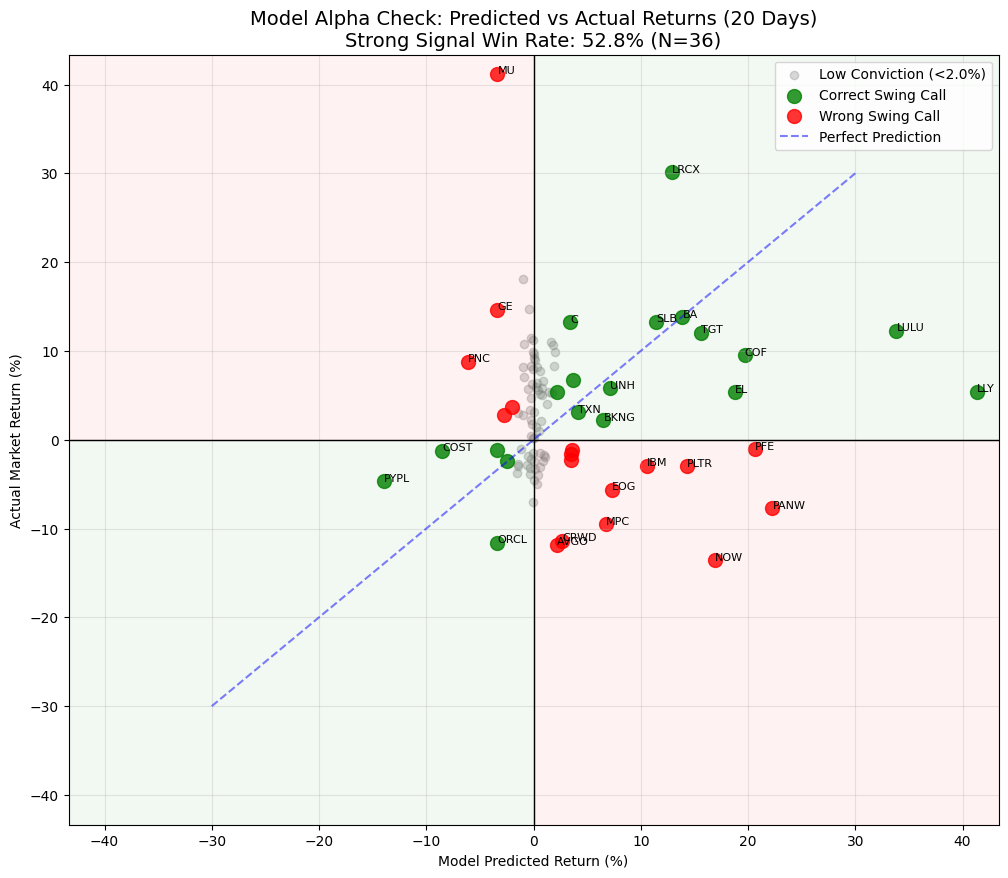


--- TRADING REPORT ---
Total Tickers Analyzed: 101
High Conviction Signals (> 2.0%): 36
Directional Accuracy on Signals: 52.8%

Top 15 Strongest Calls:
ticker       pred     actual   win
   LLY  41.353840   5.418144  True
  LULU  33.840116  12.270408  True
  PANW  22.270594  -7.739891 False
   PFE  20.626093  -1.050712 False
   COF  19.702469   9.528356  True
    EL  18.773670   5.345765  True
   NOW  16.873381 -13.549320 False
   TGT  15.632681  12.072890  True
  PLTR  14.277225  -2.998458 False
  PYPL -13.943284  -4.672447  True
    BA  13.883203  13.779785  True
  LRCX  12.902511  30.138628  True
   SLB  11.419983  13.286533  True
   IBM  10.587577  -2.938236 False
  COST  -8.495735  -1.221106  True


In [25]:
import matplotlib.pyplot as plt
import torch
from torch.nn import functional as F
import yfinance as yf
import numpy as np
import pandas as pd
import math

# --- CONFIGURATION ---
# Expanded Ticker List (~100 Major Liquid US Stocks)
tickers = [
    # Tech / Semi / Software
    'AAPL', 'MSFT', 'NVDA', 'GOOGL', 'AMZN', 'META', 'TSLA', 'AMD', 'INTC', 'QCOM',
    'AVGO', 'TXN', 'ADBE', 'CRM', 'ORCL', 'CSCO', 'IBM', 'NOW', 'UBER', 'ABNB',
    'PLTR', 'SNOW', 'PANW', 'CRWD', 'MU', 'LRCX', 'AMAT',
    
    # Finance / Banks
    'JPM', 'BAC', 'V', 'MA', 'GS', 'MS', 'WFC', 'C', 'BLK', 'AXP', 'COF', 'USB',
    'PNC', 'SCHW', 'PYPL',
    
    # Consumer Discretionary & Staples
    'WMT', 'KO', 'PEP', 'COST', 'MCD', 'DIS', 'NKE', 'SBUX', 'TGT', 'HD', 'LOW',
    'PG', 'CL', 'MO', 'PM', 'EL', 'LULU', 'CMG', 'MAR', 'BKNG',
    
    # Healthcare / Pharma
    'JNJ', 'PFE', 'UNH', 'LLY', 'MRK', 'ABBV', 'TMO', 'DHR', 'BMY', 'AMGN', 'GILD',
    'CVS', 'CI', 'ISRG', 'VRTX', 'REGN',
    
    # Industrial / Aero / Auto
    'BA', 'CAT', 'GE', 'HON', 'LMT', 'RTX', 'UPS', 'FDX', 'DE', 'MMM', 'F', 'GM',
    
    # Energy / Utilities
    'XOM', 'CVX', 'COP', 'SLB', 'EOG', 'OXY', 'MPC', 'VLO', 'NEE', 'DUK', 'SO'
]

num_simulations = 50
context_days = 60        
prediction_days = 20     
tokens_per_day = 4
block_size = 256
scale_factor = 100.0
total_price_days = context_days + prediction_days + 1

# Swing Threshold (2.0% is a solid filter for 20 days)
swing_threshold_pct = 2.0

device = 'cuda' if torch.cuda.is_available() else 'cpu'
if 'model' in globals():
    model.eval()
    model.to(device)

# --- HELPER FUNCTIONS ---
def get_closest_token(value, itos_map):
    best_id = -1
    min_diff = float('inf')
    for token_id, token_val in itos_map.items():
        if not isinstance(token_val, (int, float)): continue
        diff = abs(value - token_val)
        if diff < min_diff:
            min_diff = diff
            best_id = token_id
    return best_id

def get_backtest_data(ticker):
    try:
        df = yf.download(ticker, period="6mo", progress=False)
        if isinstance(df.columns, pd.MultiIndex):
            df.columns = df.columns.get_level_values(0)
        
        # Data integrity check
        if len(df) < total_price_days: 
            return None, None, None
        
        # Check for NaNs in the required window
        df_window = df.iloc[-total_price_days:].copy()
        if df_window.isnull().values.any():
            return None, None, None

        tokens = []
        
        for i in range(1, context_days + 1):
            prev_close = float(df_window['Close'].iloc[i-1])
            curr_open  = float(df_window['Open'].iloc[i])
            curr_high  = float(df_window['High'].iloc[i])
            curr_low   = float(df_window['Low'].iloc[i])
            curr_close = float(df_window['Close'].iloc[i])

            # Safety check for zeros
            if prev_close <= 0 or curr_open <= 0: return None, None, None

            val_open   = math.log(curr_open / prev_close) * scale_factor
            val_high   = math.log(curr_high / curr_open) * scale_factor
            val_low    = math.log(curr_low / curr_open) * scale_factor
            val_close  = math.log(curr_close / curr_open) * scale_factor

            tokens.extend([
                get_closest_token(val_open, itos),
                get_closest_token(val_high, itos),
                get_closest_token(val_low, itos),
                get_closest_token(val_close, itos)
            ])

        tensor_seq = torch.tensor(tokens, dtype=torch.long)
        if len(tensor_seq) > block_size:
            tensor_seq = tensor_seq[-block_size:] 

        # For return calculation
        entry_price = float(df_window['Close'].iloc[context_days])
        exit_price_true = float(df_window['Close'].iloc[-1])

        return tensor_seq.unsqueeze(0).to(device), entry_price, exit_price_true
    except Exception as e:
        return None, None, None

def generate_simulation(model, idx, max_new_tokens, temperature=1.0, top_k=None):
    for _ in range(max_new_tokens):
        idx_cond = idx if idx.size(1) <= block_size else idx[:, -block_size:]
        logits, _ = model(idx_cond)
        logits = logits[:, -1, :] / temperature
        if top_k is not None:
            v, _ = torch.topk(logits, top_k)
            logits[logits < v[:, [-1]]] = -float('Inf')
        probs = F.softmax(logits, dim=-1)
        idx_next = torch.multinomial(probs, num_samples=1)
        idx = torch.cat((idx, idx_next), dim=1)
    return idx

# --- ANALYSIS LOOP ---
print(f"Running Alpha Check on {len(tickers)} tickers...")
print(f"Trade Horizon: {prediction_days} days | Min Swing Threshold: {swing_threshold_pct}%")

trade_data = []

for ticker in tickers:
    print(f"Analyzing {ticker}...", end="\r")

    context_tokens, entry_price, exit_price_true = get_backtest_data(ticker)
    if context_tokens is None: 
        continue

    # 1. Run Simulation
    batch_input = context_tokens.repeat(num_simulations, 1)
    with torch.no_grad():
        generated = generate_simulation(
            model, batch_input, max_new_tokens=prediction_days * tokens_per_day,
            temperature=0.7, top_k=40
        )

    # 2. Decode Predicted Return
    future_tokens = generated[:, -prediction_days * tokens_per_day:].cpu()
    future_tokens = future_tokens.view(num_simulations, prediction_days, 4)
    
    open_tokens = future_tokens[:, :, 0]
    close_tokens = future_tokens[:, :, 3]

    sim_final_returns = []
    for sim in range(num_simulations):
        cumulative_log_return = 0.0
        for t in range(prediction_days):
            id_open = open_tokens[sim, t].item()
            val_open = itos.get(id_open, 0.0) / scale_factor
            
            id_close = close_tokens[sim, t].item()
            val_close = itos.get(id_close, 0.0) / scale_factor
            
            cumulative_log_return += (val_open + val_close)
            
        sim_final_returns.append(math.exp(cumulative_log_return)) 

    # 3. Calculate "Consensus" Forecast
    median_multiplier = np.median(sim_final_returns)
    predicted_return_pct = (median_multiplier - 1.0) * 100.0
    
    # 4. Calculate Actual Return
    actual_return_pct = (exit_price_true - entry_price) / entry_price * 100.0
    
    trade_data.append({
        'ticker': ticker,
        'pred': predicted_return_pct,
        'actual': actual_return_pct
    })

# --- TRADER'S SCATTER PLOT ---
df_trades = pd.DataFrame(trade_data)

strong_trades = df_trades[abs(df_trades['pred']) >= swing_threshold_pct]
weak_trades = df_trades[abs(df_trades['pred']) < swing_threshold_pct]

# Directional Accuracy
strong_trades = strong_trades.copy() # Avoid SettingWithCopy warning
strong_trades['win'] = np.sign(strong_trades['pred']) == np.sign(strong_trades['actual'])
win_rate = strong_trades['win'].mean() * 100 if len(strong_trades) > 0 else 0

# Plotting
plt.figure(figsize=(12, 10)) # Slightly larger for more dots

plt.scatter(weak_trades['pred'], weak_trades['actual'], color='gray', alpha=0.3, label=f'Low Conviction (<{swing_threshold_pct}%)')

wins = strong_trades[strong_trades['win'] == True]
plt.scatter(wins['pred'], wins['actual'], color='green', s=100, alpha=0.8, label='Correct Swing Call')

losses = strong_trades[strong_trades['win'] == False]
plt.scatter(losses['pred'], losses['actual'], color='red', s=100, alpha=0.8, label='Wrong Swing Call')

plt.axhline(0, color='black', linewidth=1)
plt.axvline(0, color='black', linewidth=1)
plt.plot([-30, 30], [-30, 30], color='blue', linestyle='--', alpha=0.5, label='Perfect Prediction')

# Only label the most extreme outliers to avoid clutter
for i, row in strong_trades.iterrows():
    if abs(row['pred']) > 4.0 or abs(row['actual']) > 8.0:
        plt.text(row['pred'], row['actual'], row['ticker'], fontsize=8)

plt.title(f"Model Alpha Check: Predicted vs Actual Returns (20 Days)\nStrong Signal Win Rate: {win_rate:.1f}% (N={len(strong_trades)})", fontsize=14)
plt.xlabel("Model Predicted Return (%)")
plt.ylabel("Actual Market Return (%)")
plt.legend()
plt.grid(True, alpha=0.3)

# Dynamic Limits
all_vals = np.concatenate([df_trades['pred'].values, df_trades['actual'].values])
limit = max(abs(all_vals.min()), abs(all_vals.max())) + 2
plt.xlim(-limit, limit)
plt.ylim(-limit, limit)

# Quadrants
plt.fill_between([0, limit], 0, limit, color='green', alpha=0.05)   
plt.fill_between([-limit, 0], -limit, 0, color='green', alpha=0.05) 
plt.fill_between([0, limit], -limit, 0, color='red', alpha=0.05)    
plt.fill_between([-limit, 0], 0, limit, color='red', alpha=0.05)    

plt.savefig('alpha_scatter_plot_extended.png', dpi=300, bbox_inches='tight')
print("\nPlot saved to alpha_scatter_plot_extended.png")
plt.show()

# --- PRINT STATS ---
print("\n--- TRADING REPORT ---")
print(f"Total Tickers Analyzed: {len(df_trades)}")
print(f"High Conviction Signals (> {swing_threshold_pct}%): {len(strong_trades)}")
print(f"Directional Accuracy on Signals: {win_rate:.1f}%")
if len(strong_trades) > 0:
    print("\nTop 15 Strongest Calls:")
    print(strong_trades[['ticker', 'pred', 'actual', 'win']].sort_values(by='pred', key=abs, ascending=False).head(15).to_string(index=False))

Running Risk-Adjusted Alpha Check on 101 tickers...
Analyzing SO......
--- PROFITABILITY ANALYSIS (20 Day Trade) ---
Naive Strategy (Equal Bets > 2.0%):
  Total PnL: $1150.23
  ROI:       3.59%
------------------------------
Smart Strategy (Weighted by Conviction Score):
  Total PnL: $441.06
  ROI:       1.04%
------------------------------

Top 10 High Conviction Bets (Where the model went 'All In'):
ticker  pred_return  pred_risk  conviction    smart_bet  actual_return   smart_pnl
   LLY    40.106157  15.705813    2.553587  2553.586769       5.215231  133.175454
   PFE    17.937475   8.512572    2.107175  2107.174527      -1.248181  -26.301357
   TGT    15.927352   7.611806    2.092454  2092.453704      12.842168  268.716426
  LULU    30.371676  16.289326    1.864514  1864.513948      13.083523  243.944104
   PNC    -5.434924   3.070453   -1.770072 -1770.072434       9.107452 -161.208495
   COF    18.363401  10.569297    1.737429  1737.428841      10.352005  179.858724
  PYPL   -15.8

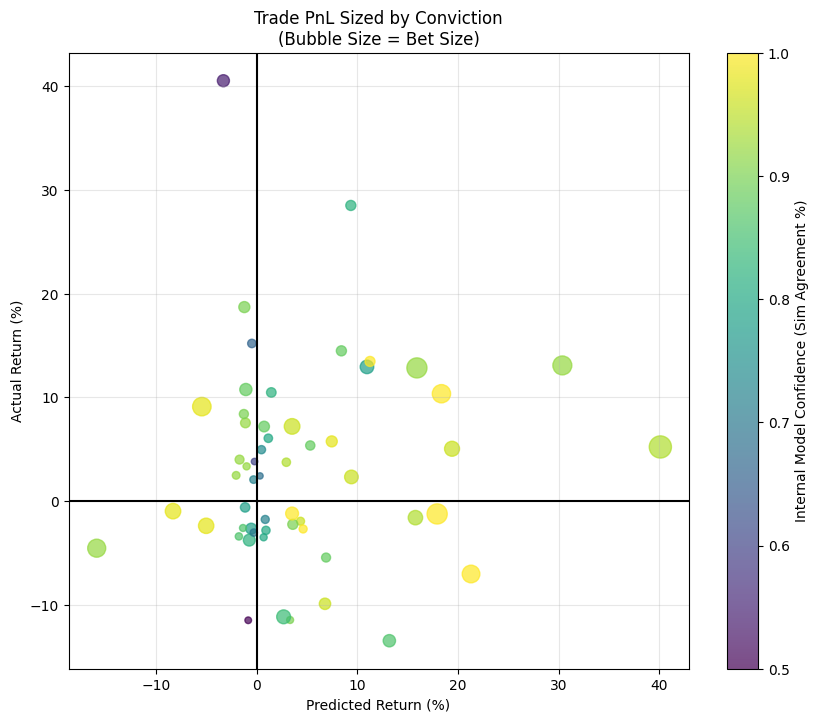

In [26]:
import matplotlib.pyplot as plt
import torch
from torch.nn import functional as F
import yfinance as yf
import numpy as np
import pandas as pd
import math

# --- CONFIGURATION ---
tickers = [
    'AAPL', 'MSFT', 'NVDA', 'GOOGL', 'AMZN', 'META', 'TSLA', 'AMD', 'INTC', 'QCOM',
    'AVGO', 'TXN', 'ADBE', 'CRM', 'ORCL', 'CSCO', 'IBM', 'NOW', 'UBER', 'ABNB',
    'PLTR', 'SNOW', 'PANW', 'CRWD', 'MU', 'LRCX', 'AMAT',
    'JPM', 'BAC', 'V', 'MA', 'GS', 'MS', 'WFC', 'C', 'BLK', 'AXP', 'COF', 'USB',
    'PNC', 'SCHW', 'PYPL',
    'WMT', 'KO', 'PEP', 'COST', 'MCD', 'DIS', 'NKE', 'SBUX', 'TGT', 'HD', 'LOW',
    'PG', 'CL', 'MO', 'PM', 'EL', 'LULU', 'CMG', 'MAR', 'BKNG',
    'JNJ', 'PFE', 'UNH', 'LLY', 'MRK', 'ABBV', 'TMO', 'DHR', 'BMY', 'AMGN', 'GILD',
    'CVS', 'CI', 'ISRG', 'VRTX', 'REGN',
    'BA', 'CAT', 'GE', 'HON', 'LMT', 'RTX', 'UPS', 'FDX', 'DE', 'MMM', 'F', 'GM',
    'XOM', 'CVX', 'COP', 'SLB', 'EOG', 'OXY', 'MPC', 'VLO', 'NEE', 'DUK', 'SO'
]

num_simulations = 50
context_days = 60        
prediction_days = 20     
tokens_per_day = 4
block_size = 256
scale_factor = 100.0
total_price_days = context_days + prediction_days + 1
swing_threshold_pct = 2.0

device = 'cuda' if torch.cuda.is_available() else 'cpu'
if 'model' in globals():
    model.eval()
    model.to(device)

# --- HELPER FUNCTIONS (Same as before) ---
def get_closest_token(value, itos_map):
    best_id = -1
    min_diff = float('inf')
    for token_id, token_val in itos_map.items():
        if not isinstance(token_val, (int, float)): continue
        diff = abs(value - token_val)
        if diff < min_diff:
            min_diff = diff
            best_id = token_id
    return best_id

def get_backtest_data(ticker):
    try:
        df = yf.download(ticker, period="6mo", progress=False)
        if isinstance(df.columns, pd.MultiIndex):
            df.columns = df.columns.get_level_values(0)
        
        if len(df) < total_price_days: return None, None, None
        
        df_window = df.iloc[-total_price_days:].copy()
        tokens = []
        
        for i in range(1, context_days + 1):
            prev_close = float(df_window['Close'].iloc[i-1])
            curr_open  = float(df_window['Open'].iloc[i])
            curr_high  = float(df_window['High'].iloc[i])
            curr_low   = float(df_window['Low'].iloc[i])
            curr_close = float(df_window['Close'].iloc[i])

            if prev_close <= 0 or curr_open <= 0: return None, None, None

            val_open   = math.log(curr_open / prev_close) * scale_factor
            val_high   = math.log(curr_high / curr_open) * scale_factor
            val_low    = math.log(curr_low / curr_open) * scale_factor
            val_close  = math.log(curr_close / curr_open) * scale_factor

            tokens.extend([
                get_closest_token(val_open, itos),
                get_closest_token(val_high, itos),
                get_closest_token(val_low, itos),
                get_closest_token(val_close, itos)
            ])

        tensor_seq = torch.tensor(tokens, dtype=torch.long)
        if len(tensor_seq) > block_size:
            tensor_seq = tensor_seq[-block_size:] 

        entry_price = float(df_window['Close'].iloc[context_days])
        exit_price_true = float(df_window['Close'].iloc[-1])

        return tensor_seq.unsqueeze(0).to(device), entry_price, exit_price_true
    except:
        return None, None, None

def generate_simulation(model, idx, max_new_tokens, temperature=1.0, top_k=None):
    for _ in range(max_new_tokens):
        idx_cond = idx if idx.size(1) <= block_size else idx[:, -block_size:]
        logits, _ = model(idx_cond)
        logits = logits[:, -1, :] / temperature
        if top_k is not None:
            v, _ = torch.topk(logits, top_k)
            logits[logits < v[:, [-1]]] = -float('Inf')
        probs = F.softmax(logits, dim=-1)
        idx_next = torch.multinomial(probs, num_samples=1)
        idx = torch.cat((idx, idx_next), dim=1)
    return idx

# --- ANALYSIS LOOP WITH RISK METRICS ---
print(f"Running Risk-Adjusted Alpha Check on {len(tickers)} tickers...")
risk_data = []

for ticker in tickers:
    print(f"Analyzing {ticker}...", end="\r")

    context_tokens, entry_price, exit_price_true = get_backtest_data(ticker)
    if context_tokens is None: continue

    # 1. Run Simulation
    batch_input = context_tokens.repeat(num_simulations, 1)
    with torch.no_grad():
        generated = generate_simulation(
            model, batch_input, max_new_tokens=prediction_days * tokens_per_day,
            temperature=0.7, top_k=40
        )

    # 2. Decode Returns
    future_tokens = generated[:, -prediction_days * tokens_per_day:].cpu()
    future_tokens = future_tokens.view(num_simulations, prediction_days, 4)
    open_tokens = future_tokens[:, :, 0]
    close_tokens = future_tokens[:, :, 3]

    sim_final_returns_pct = []
    
    for sim in range(num_simulations):
        cumulative_log_return = 0.0
        for t in range(prediction_days):
            val_open = itos.get(open_tokens[sim, t].item(), 0.0) / scale_factor
            val_close = itos.get(close_tokens[sim, t].item(), 0.0) / scale_factor
            cumulative_log_return += (val_open + val_close)
        
        total_return_pct = (math.exp(cumulative_log_return) - 1.0) * 100.0
        sim_final_returns_pct.append(total_return_pct)

    # 3. Calculate Risk/Reward Metrics (The "Conviction" Heuristic)
    sim_returns = np.array(sim_final_returns_pct)
    
    # Reward: Median Return
    pred_return = np.median(sim_returns)
    
    # Risk: Standard Deviation of Simulations (Internal Uncertainty)
    pred_risk = np.std(sim_returns) + 1e-6 # Avoid div by zero
    
    # Heuristic: Sharpe-like Score (Conviction)
    # How much return per unit of model uncertainty?
    conviction_score = pred_return / pred_risk
    
    # Internal Win Probability (How many sims agreed with the direction?)
    if pred_return > 0:
        win_prob_internal = (sim_returns > 0).mean()
    else:
        win_prob_internal = (sim_returns < 0).mean()

    # Actual Outcome
    actual_return_pct = (exit_price_true - entry_price) / entry_price * 100.0
    
    risk_data.append({
        'ticker': ticker,
        'pred_return': pred_return,
        'pred_risk': pred_risk,
        'conviction': conviction_score,
        'internal_win_prob': win_prob_internal,
        'actual_return': actual_return_pct
    })

# --- PROFITABILITY SIMULATION ---
df = pd.DataFrame(risk_data)

# Strategy 1: Naive (Equal Bet on anything > 2%)
# Buy $1000 of every stock where pred > 2%
df['naive_bet'] = df['pred_return'].apply(lambda x: 1000 if abs(x) > swing_threshold_pct else 0)
df['naive_pnl'] = (df['naive_bet'] * df['actual_return']) / 100

# Strategy 2: "Smart Kelly" (Conviction Weighted)
# Bet Size = Base * Conviction Score
# If Conviction is 2.0 (High), bet $2000. If 0.5 (Low), bet $500.
# We clip the conviction to avoid infinite leverage on accidental low-variance stocks.
df['smart_bet'] = df['conviction'].apply(lambda x: 1000 * min(abs(x), 3.0) if abs(x) > 0.2 else 0)
# Make bet direction match prediction
df['smart_bet'] *= np.sign(df['pred_return']) 
df['smart_pnl'] = (df['smart_bet'] * df['actual_return']) / 100

# --- RESULTS ---
naive_total = df['naive_pnl'].sum()
smart_total = df['smart_pnl'].sum()
naive_roi = (naive_total / df['naive_bet'].abs().sum()) * 100 if df['naive_bet'].abs().sum() > 0 else 0
smart_roi = (smart_total / df['smart_bet'].abs().sum()) * 100 if df['smart_bet'].abs().sum() > 0 else 0

print("\n--- PROFITABILITY ANALYSIS (20 Day Trade) ---")
print(f"Naive Strategy (Equal Bets > {swing_threshold_pct}%):")
print(f"  Total PnL: ${naive_total:.2f}")
print(f"  ROI:       {naive_roi:.2f}%")
print("-" * 30)
print(f"Smart Strategy (Weighted by Conviction Score):")
print(f"  Total PnL: ${smart_total:.2f}")
print(f"  ROI:       {smart_roi:.2f}%")
print("-" * 30)

# Show Top "Smart" Trades
print("\nTop 10 High Conviction Bets (Where the model went 'All In'):")
cols = ['ticker', 'pred_return', 'pred_risk', 'conviction', 'smart_bet', 'actual_return', 'smart_pnl']
print(df.sort_values(by='smart_bet', key=abs, ascending=False).head(10)[cols].to_string(index=False))

# Scatter Plot colored by Conviction
plt.figure(figsize=(10, 8))
sc = plt.scatter(df['pred_return'], df['actual_return'], c=df['internal_win_prob'], cmap='viridis', s=df['smart_bet'].abs()/10, alpha=0.7)
plt.colorbar(sc, label='Internal Model Confidence (Sim Agreement %)')
plt.axhline(0, color='black'); plt.axvline(0, color='black')
plt.title("Trade PnL Sized by Conviction\n(Bubble Size = Bet Size)")
plt.xlabel("Predicted Return (%)")
plt.ylabel("Actual Return (%)")
plt.grid(True, alpha=0.3)
plt.savefig('profitability_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

Running Rolling Window Validation (3 Periods)...

Processing Window: Offset -0 days...
  CVX.....
Processing Window: Offset -20 days...
  CVX.....
Processing Window: Offset -40 days...
  CVX.....
ROBUSTNESS CHECK: Performance by Time Period
Period T-0 days:
  High Conviction Signals: 6
  Directional Win Rate:    50.0%
--------------------
Period T-20 days:
  High Conviction Signals: 16
  Directional Win Rate:    56.2%
--------------------
Period T-40 days:
  High Conviction Signals: 10
  Directional Win Rate:    70.0%
--------------------

OVERALL ROBUSTNESS (All Periods Combined):
Total High Conviction Trades: 32
Aggregate Win Rate:           59.4%


/run/nvme/job_31093539/tmp/ipykernel_2004175/1227489102.py:178: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  strong['win'] = np.sign(strong['pred']) == np.sign(strong['actual'])
/run/nvme/job_31093539/tmp/ipykernel_2004175/1227489102.py:178: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  strong['win'] = np.sign(strong['pred']) == np.sign(strong['actual'])
/run/nvme/job_31093539/tmp/ipykernel_2004175/1227489102.py:178: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

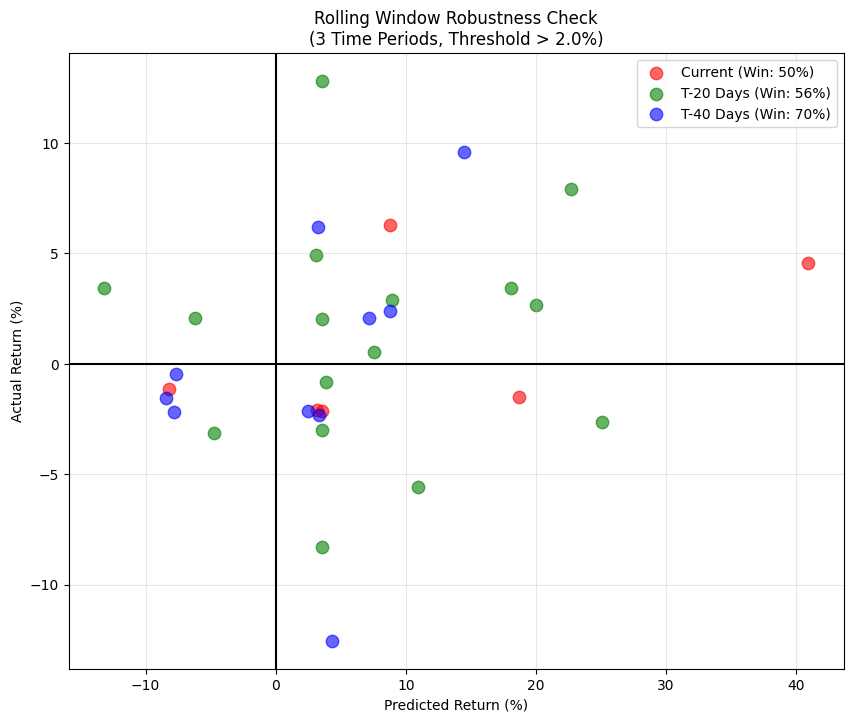

In [27]:
import matplotlib.pyplot as plt
import torch
from torch.nn import functional as F
import yfinance as yf
import numpy as np
import pandas as pd
import math

# --- CONFIGURATION ---
tickers = [
    'AAPL', 'MSFT', 'NVDA', 'GOOGL', 'AMZN', 'META', 'TSLA', 'AMD',
    'JPM', 'BAC', 'V', 'MA', 'GS',
    'WMT', 'KO', 'PEP', 'COST', 'MCD', 'DIS',
    'JNJ', 'PFE', 'UNH', 'LLY',
    'XOM', 'CVX'
] # (You can use the full 100 ticker list here if you want)

num_simulations = 50
context_days = 60
prediction_days = 20
tokens_per_day = 4
block_size = 256
scale_factor = 100.0
total_price_days = context_days + prediction_days + 1
swing_threshold_pct = 2.0

# Define the Rolling Windows (Offsets from "Today")
# 0 = Most recent 20 days
# 20 = The 20 days before that
# 40 = The 20 days before that
offsets = [0, 20, 40] 

device = 'cuda' if torch.cuda.is_available() else 'cpu'
if 'model' in globals():
    model.eval()
    model.to(device)

# --- HELPER FUNCTIONS ---
def get_closest_token(value, itos_map):
    best_id = -1
    min_diff = float('inf')
    for token_id, token_val in itos_map.items():
        if not isinstance(token_val, (int, float)): continue
        diff = abs(value - token_val)
        if diff < min_diff:
            min_diff = diff
            best_id = token_id
    return best_id

def get_shifted_window(ticker, offset):
    try:
        # Fetch enough history to cover the largest offset
        df = yf.download(ticker, period="1y", progress=False)
        if isinstance(df.columns, pd.MultiIndex):
            df.columns = df.columns.get_level_values(0)
        
        # Determine slice indices
        # If offset is 0, we take the last 'total_price_days'
        # If offset is 20, we end 20 days ago
        if offset == 0:
            df_window = df.iloc[-total_price_days:].copy()
        else:
            df_window = df.iloc[-(total_price_days + offset) : -offset].copy()
            
        if len(df_window) < total_price_days: return None, None, None
        
        # Check for bad data
        if df_window.isnull().values.any() or (df_window['Close'] <= 0).any():
            return None, None, None

        tokens = []
        for i in range(1, context_days + 1):
            prev_close = float(df_window['Close'].iloc[i-1])
            curr_open  = float(df_window['Open'].iloc[i])
            curr_high  = float(df_window['High'].iloc[i])
            curr_low   = float(df_window['Low'].iloc[i])
            curr_close = float(df_window['Close'].iloc[i])

            val_open   = math.log(curr_open / prev_close) * scale_factor
            val_high   = math.log(curr_high / curr_open) * scale_factor
            val_low    = math.log(curr_low / curr_open) * scale_factor
            val_close  = math.log(curr_close / curr_open) * scale_factor

            tokens.extend([
                get_closest_token(val_open, itos),
                get_closest_token(val_high, itos),
                get_closest_token(val_low, itos),
                get_closest_token(val_close, itos)
            ])

        tensor_seq = torch.tensor(tokens, dtype=torch.long)
        if len(tensor_seq) > block_size:
            tensor_seq = tensor_seq[-block_size:] 

        entry_price = float(df_window['Close'].iloc[context_days])
        exit_price_true = float(df_window['Close'].iloc[-1])

        return tensor_seq.unsqueeze(0).to(device), entry_price, exit_price_true
    except:
        return None, None, None

def generate_simulation(model, idx, max_new_tokens, temperature=1.0, top_k=None):
    for _ in range(max_new_tokens):
        idx_cond = idx if idx.size(1) <= block_size else idx[:, -block_size:]
        logits, _ = model(idx_cond)
        logits = logits[:, -1, :] / temperature
        if top_k is not None:
            v, _ = torch.topk(logits, top_k)
            logits[logits < v[:, [-1]]] = -float('Inf')
        probs = F.softmax(logits, dim=-1)
        idx_next = torch.multinomial(probs, num_samples=1)
        idx = torch.cat((idx, idx_next), dim=1)
    return idx

# --- ROLLING WINDOW ANALYSIS ---
print(f"Running Rolling Window Validation ({len(offsets)} Periods)...")

all_periods_data = []

for offset in offsets:
    print(f"\nProcessing Window: Offset -{offset} days...")
    period_trades = []
    
    for ticker in tickers:
        print(f"  {ticker}...", end="\r")
        context_tokens, entry_price, exit_price_true = get_shifted_window(ticker, offset)
        if context_tokens is None: continue

        # Run Simulation
        batch_input = context_tokens.repeat(num_simulations, 1)
        with torch.no_grad():
            generated = generate_simulation(
                model, batch_input, max_new_tokens=prediction_days * tokens_per_day,
                temperature=0.7, top_k=40
            )

        # Decode
        future_tokens = generated[:, -prediction_days * tokens_per_day:].cpu()
        future_tokens = future_tokens.view(num_simulations, prediction_days, 4)
        open_tokens = future_tokens[:, :, 0]
        close_tokens = future_tokens[:, :, 3]

        sim_final_returns = []
        for sim in range(num_simulations):
            cumulative_log = 0.0
            for t in range(prediction_days):
                val_open = itos.get(open_tokens[sim, t].item(), 0.0) / scale_factor
                val_close = itos.get(close_tokens[sim, t].item(), 0.0) / scale_factor
                cumulative_log += (val_open + val_close)
            sim_final_returns.append(math.exp(cumulative_log))

        median_mult = np.median(sim_final_returns)
        pred_pct = (median_mult - 1.0) * 100.0
        actual_pct = (exit_price_true - entry_price) / entry_price * 100.0
        
        period_trades.append({
            'ticker': ticker,
            'offset': offset,
            'pred': pred_pct,
            'actual': actual_pct
        })
    
    all_periods_data.extend(period_trades)

# --- AGGREGATE RESULTS ---
df_all = pd.DataFrame(all_periods_data)

# Analysis per Period
print("\n" + "="*40)
print("ROBUSTNESS CHECK: Performance by Time Period")
print("="*40)

for offset in offsets:
    subset = df_all[df_all['offset'] == offset].copy()
    strong = subset[abs(subset['pred']) >= swing_threshold_pct]
    
    if len(strong) > 0:
        strong['win'] = np.sign(strong['pred']) == np.sign(strong['actual'])
        win_rate = strong['win'].mean() * 100
        print(f"Period T-{offset} days:")
        print(f"  High Conviction Signals: {len(strong)}")
        print(f"  Directional Win Rate:    {win_rate:.1f}%")
    else:
        print(f"Period T-{offset} days: No strong signals found.")
    print("-" * 20)

# Total Aggregate Stats
strong_all = df_all[abs(df_all['pred']) >= swing_threshold_pct].copy()
strong_all['win'] = np.sign(strong_all['pred']) == np.sign(strong_all['actual'])
total_win_rate = strong_all['win'].mean() * 100

print(f"\nOVERALL ROBUSTNESS (All Periods Combined):")
print(f"Total High Conviction Trades: {len(strong_all)}")
print(f"Aggregate Win Rate:           {total_win_rate:.1f}%")

# Scatter Plot (Color-coded by Period)
plt.figure(figsize=(10, 8))
colors = {0: 'red', 20: 'green', 40: 'blue'}
labels = {0: 'Current', 20: 'T-20 Days', 40: 'T-40 Days'}

for offset in offsets:
    subset = strong_all[strong_all['offset'] == offset]
    plt.scatter(subset['pred'], subset['actual'], 
                color=colors[offset], alpha=0.6, s=80, 
                label=f"{labels[offset]} (Win: {subset['win'].mean()*100:.0f}%)")

plt.axhline(0, color='black'); plt.axvline(0, color='black')
plt.title(f"Rolling Window Robustness Check\n(3 Time Periods, Threshold > {swing_threshold_pct}%)")
plt.xlabel("Predicted Return (%)")
plt.ylabel("Actual Return (%)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('robustness_check.png', dpi=300, bbox_inches='tight')
plt.show()

Starting Robustness Check: 107 Tickers x 12 Windows...
Total potential trade setups: 1284

Processing Window T-0 days...
Processing Window T-20 days...
Processing Window T-40 days...
Processing Window T-60 days...
Processing Window T-80 days...
Processing Window T-100 days...
Processing Window T-120 days...
Processing Window T-140 days...
Processing Window T-160 days...
Processing Window T-180 days...
Processing Window T-200 days...
Processing Window T-220 days...
THESIS RESULTS: Naive vs. LLM-Conviction Strategy
Total Signals Generated: 636
Naive Strategy Total PnL: $6,879.49
Naive Trade Sharpe:       0.101
------------------------------
Smart Strategy Total PnL: $8,752.85
Smart Trade Sharpe:       0.098


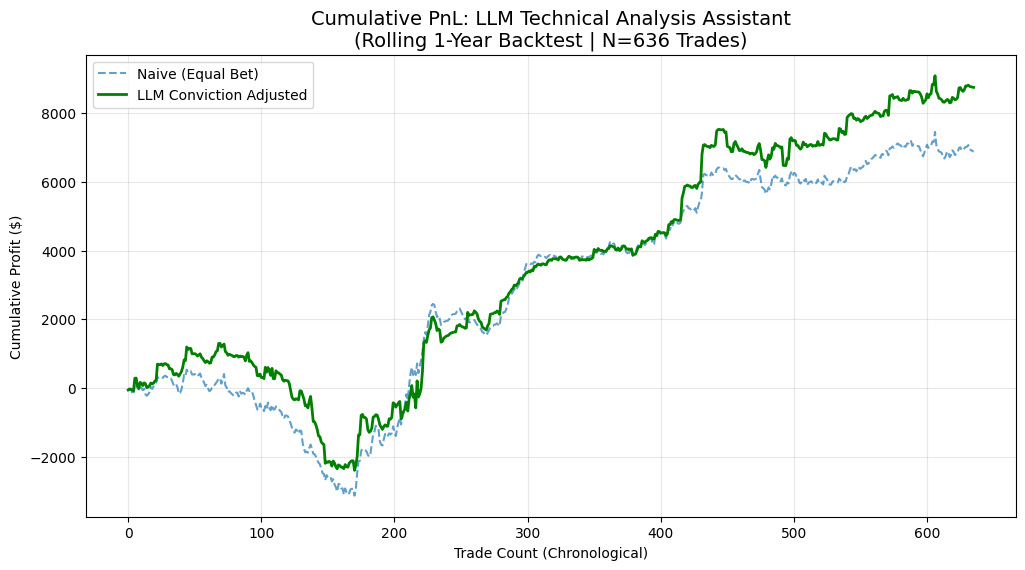


Overall Directional Accuracy: 51.26%


In [28]:
import matplotlib.pyplot as plt
import torch
from torch.nn import functional as F
import yfinance as yf
import numpy as np
import pandas as pd
import math

# --- 1. CONFIGURATION ---
# Broad Market Coverage (Tech, Finance, Health, Energy, Staples, Industrials)
tickers = [
    'AAPL', 'MSFT', 'NVDA', 'GOOGL', 'AMZN', 'META', 'TSLA', 'AMD', 'INTC', 'QCOM',
    'AVGO', 'TXN', 'ADBE', 'CRM', 'ORCL', 'CSCO', 'IBM', 'NOW', 'UBER', 'ABNB',
    'PLTR', 'SNOW', 'PANW', 'CRWD', 'MU', 'LRCX', 'AMAT', 'NFLX', 'SPOT',
    'JPM', 'BAC', 'V', 'MA', 'GS', 'MS', 'WFC', 'C', 'BLK', 'AXP', 'COF', 'USB',
    'PNC', 'SCHW', 'PYPL', 'SPGI', 'MCO',
    'WMT', 'KO', 'PEP', 'COST', 'MCD', 'DIS', 'NKE', 'SBUX', 'TGT', 'HD', 'LOW',
    'PG', 'CL', 'MO', 'PM', 'EL', 'LULU', 'CMG', 'MAR', 'BKNG', 'TSCO',
    'JNJ', 'PFE', 'UNH', 'LLY', 'MRK', 'ABBV', 'TMO', 'DHR', 'BMY', 'AMGN', 'GILD',
    'CVS', 'CI', 'ISRG', 'VRTX', 'REGN', 'ZTS',
    'BA', 'CAT', 'GE', 'HON', 'LMT', 'RTX', 'UPS', 'FDX', 'DE', 'MMM', 'F', 'GM',
    'XOM', 'CVX', 'COP', 'SLB', 'EOG', 'OXY', 'MPC', 'VLO', 'NEE', 'DUK', 'SO'
]

num_simulations = 50
context_days = 60
prediction_days = 20
tokens_per_day = 4
block_size = 256
scale_factor = 100.0
total_price_days = context_days + prediction_days + 1
swing_threshold_pct = 2.0  # Minimum predicted move to take a trade

# 12 Windows of 20 days = ~240 trading days (~1 Year Backtest)
# We step back 20 days at a time.
rolling_offsets = [i * 20 for i in range(12)] 

device = 'cuda' if torch.cuda.is_available() else 'cpu'
if 'model' in globals():
    model.eval()
    model.to(device)

# --- 2. HELPER FUNCTIONS ---
def get_closest_token(value, itos_map):
    best_id = -1
    min_diff = float('inf')
    for token_id, token_val in itos_map.items():
        if not isinstance(token_val, (int, float)): continue
        diff = abs(value - token_val)
        if diff < min_diff:
            min_diff = diff
            best_id = token_id
    return best_id

def generate_simulation(model, idx, max_new_tokens, temperature=1.0, top_k=None):
    for _ in range(max_new_tokens):
        idx_cond = idx if idx.size(1) <= block_size else idx[:, -block_size:]
        logits, _ = model(idx_cond)
        logits = logits[:, -1, :] / temperature
        if top_k is not None:
            v, _ = torch.topk(logits, top_k)
            logits[logits < v[:, [-1]]] = -float('Inf')
        probs = F.softmax(logits, dim=-1)
        idx_next = torch.multinomial(probs, num_samples=1)
        idx = torch.cat((idx, idx_next), dim=1)
    return idx

# --- 3. MASSIVE BACKTEST LOOP ---
print(f"Starting Robustness Check: {len(tickers)} Tickers x {len(rolling_offsets)} Windows...")
print(f"Total potential trade setups: {len(tickers) * len(rolling_offsets)}")

all_trades = []

# Download all data once to save time (2 years to cover all windows)
print("Downloading batch market data...")
data_batch = yf.download(tickers, period="2y", group_by='ticker', progress=False)

for offset in rolling_offsets:
    print(f"\nProcessing Window T-{offset} days...", end="")
    
    for ticker in tickers:
        try:
            # Handle yfinance multi-index structure
            if len(tickers) > 1:
                df = data_batch[ticker].copy()
            else:
                df = data_batch.copy()
            
            # Slice the specific window for this offset
            # If offset is 0, end is the last day. If 20, end is -20.
            end_idx = -offset if offset > 0 else len(df)
            start_idx = end_idx - total_price_days
            
            # Bounds Check
            if end_idx > len(df) or abs(start_idx) > len(df): continue
            
            # Extract Window
            if offset == 0:
                df_window = df.iloc[start_idx:].copy()
            else:
                df_window = df.iloc[start_idx:end_idx].copy()
            
            # Data Validity Check
            if len(df_window) != total_price_days: continue
            if df_window.isnull().values.any(): continue
            
            # --- TOKENIZATION ---
            tokens = []
            valid_window = True
            for i in range(1, context_days + 1):
                prev_close = float(df_window['Close'].iloc[i-1])
                curr_open  = float(df_window['Open'].iloc[i])
                curr_high  = float(df_window['High'].iloc[i])
                curr_low   = float(df_window['Low'].iloc[i])
                curr_close = float(df_window['Close'].iloc[i])
                
                if prev_close <= 0 or curr_open <= 0: 
                    valid_window = False; break

                val_open   = math.log(curr_open / prev_close) * scale_factor
                val_high   = math.log(curr_high / curr_open) * scale_factor
                val_low    = math.log(curr_low / curr_open) * scale_factor
                val_close  = math.log(curr_close / curr_open) * scale_factor

                tokens.extend([
                    get_closest_token(val_open, itos), get_closest_token(val_high, itos),
                    get_closest_token(val_low, itos), get_closest_token(val_close, itos)
                ])
            
            if not valid_window: continue

            tensor_seq = torch.tensor(tokens, dtype=torch.long).unsqueeze(0).to(device)
            if tensor_seq.size(1) > block_size: tensor_seq = tensor_seq[:, -block_size:]

            # --- SIMULATION ---
            batch_input = tensor_seq.repeat(num_simulations, 1)
            with torch.no_grad():
                generated = generate_simulation(
                    model, batch_input, max_new_tokens=prediction_days * tokens_per_day,
                    temperature=0.7, top_k=40
                )

            # --- DECODING (GAP + INTRADAY FIX) ---
            future_tokens = generated[:, -prediction_days * tokens_per_day:].cpu()
            future_tokens = future_tokens.view(num_simulations, prediction_days, 4)
            open_tokens = future_tokens[:, :, 0]
            close_tokens = future_tokens[:, :, 3]

            sim_returns_pct = []
            for sim in range(num_simulations):
                log_ret = 0.0
                for t in range(prediction_days):
                    v_open = itos.get(open_tokens[sim, t].item(), 0.0) / scale_factor
                    v_close = itos.get(close_tokens[sim, t].item(), 0.0) / scale_factor
                    log_ret += (v_open + v_close)
                sim_returns_pct.append((math.exp(log_ret) - 1.0) * 100.0)

            # --- METRICS CALCULATION ---
            arr_returns = np.array(sim_returns_pct)
            pred_return = np.median(arr_returns)
            pred_risk   = np.std(arr_returns) + 1e-6
            
            # Conviction Score = Return per unit of Variance (Sharpe-like)
            conviction = pred_return / pred_risk

            # Actual Outcome
            entry_price = float(df_window['Close'].iloc[context_days])
            exit_price  = float(df_window['Close'].iloc[-1])
            actual_return = (exit_price - entry_price) / entry_price * 100.0

            all_trades.append({
                'ticker': ticker,
                'offset': offset,
                'pred_return': pred_return,
                'pred_risk': pred_risk,
                'conviction': conviction,
                'actual_return': actual_return
            })
            
        except Exception as e:
            continue

# --- 4. STRATEGY SIMULATION ---
df = pd.DataFrame(all_trades)

# Filter: Only consider signals where model predicted > 2% move (up or down)
df_signals = df[abs(df['pred_return']) >= swing_threshold_pct].copy()

# Strategy A: Naive (Equal Weight)
# Bet $1000 on every signal
df_signals['naive_bet'] = 1000 * np.sign(df_signals['pred_return'])
df_signals['naive_pnl'] = (df_signals['naive_bet'] * df_signals['actual_return']) / 100.0

# Strategy B: Conviction Weighted
# Bet $1000 * Conviction Score (Capped at 3x leverage)
# Logic: If model sees high return with LOW variance, bet big.
df_signals['smart_bet'] = 1000 * df_signals['conviction'].apply(lambda x: min(abs(x), 3.0)) * np.sign(df_signals['pred_return'])
df_signals['smart_pnl'] = (df_signals['smart_bet'] * df_signals['actual_return']) / 100.0

# --- 5. RESULTS & PLOTTING ---
print("\n" + "="*50)
print("THESIS RESULTS: Naive vs. LLM-Conviction Strategy")
print("="*50)
print(f"Total Signals Generated: {len(df_signals)}")

# Cumulative PnL (Sort by Offset descending to simulate time passing)
df_signals = df_signals.sort_values(by='offset', ascending=False) # Offset 200 -> Offset 0
df_signals['cumsum_naive'] = df_signals['naive_pnl'].cumsum()
df_signals['cumsum_smart'] = df_signals['smart_pnl'].cumsum()

total_naive = df_signals['naive_pnl'].sum()
total_smart = df_signals['smart_pnl'].sum()
naive_sharpe = df_signals['naive_pnl'].mean() / df_signals['naive_pnl'].std()
smart_sharpe = df_signals['smart_pnl'].mean() / df_signals['smart_pnl'].std()

print(f"Naive Strategy Total PnL: ${total_naive:,.2f}")
print(f"Naive Trade Sharpe:       {naive_sharpe:.3f}")
print("-" * 30)
print(f"Smart Strategy Total PnL: ${total_smart:,.2f}")
print(f"Smart Trade Sharpe:       {smart_sharpe:.3f}")

# Plot
plt.figure(figsize=(12, 6))
# We map offsets to a dummy "Trade Number" axis
x_axis = range(len(df_signals))
plt.plot(x_axis, df_signals['cumsum_naive'], label='Naive (Equal Bet)', linestyle='--', alpha=0.7)
plt.plot(x_axis, df_signals['cumsum_smart'], label='LLM Conviction Adjusted', linewidth=2, color='green')

plt.title(f"Cumulative PnL: LLM Technical Analysis Assistant\n(Rolling 1-Year Backtest | N={len(df_signals)} Trades)", fontsize=14)
plt.xlabel("Trade Count (Chronological)")
plt.ylabel("Cumulative Profit ($)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('thesis_cumulative_pnl.png', dpi=300, bbox_inches='tight')
plt.show()

# Win Rate Analysis
win_rate = (np.sign(df_signals['pred_return']) == np.sign(df_signals['actual_return'])).mean() * 100
print(f"\nOverall Directional Accuracy: {win_rate:.2f}%")

Running on: CUDA
Initializing Massive Backtest: 69 Tickers from 2021-01-01
Step 1/3: Downloading market data...


Fetching Chunks:   0%|          | 0/2 [00:00<?, ?it/s]HTTP Error 404: {"quoteSummary":{"result":null,"error":{"code":"Not Found","description":"Quote not found for symbol: ADD FOR FINAL RUNS"}}}
$ ADD FOR FINAL RUNS
    # US FINANCE
    'JPM': 'US_FIN', 'BAC': 'US_FIN', 'V': 'US_FIN', 'MA': 'US_FIN', 'GS': 'US_FIN',
    'MS': 'US_FIN', 'WFC': 'US_FIN', 'C': 'US_FIN', 'BLK': 'US_FIN', 'AXP': 'US_FIN',
    'COF': 'US_FIN', 'USB': 'US_FIN', 'PNC': 'US_FIN', 'SCHW': 'US_FIN', 'PYPL': 'US_FIN',
    'SPGI': 'US_FIN', 'MCO': 'US_FIN', 'CB': 'US_FIN', 'MMC': 'US_FIN', 'AON': 'US_FIN',
    'PGR': 'US_FIN', 'TRV': 'US_FIN', 'ALL': 'US_FIN', 'BK': 'US_FIN', 'STT': 'US_FIN',

    # US HEALTHCARE
    'JNJ': 'US_HEALTH', 'PFE': 'US_HEALTH', 'UNH': 'US_HEALTH', 'LLY': 'US_HEALTH', 'MRK': 'US_HEALTH',
    'ABBV': 'US_HEALTH', 'TMO': 'US_HEALTH', 'DHR': 'US_HEALTH', 'BMY': 'US_HEALTH', 'AMGN': 'US_HEALTH',
    'GILD': 'US_HEALTH', 'CVS': 'US_HEALTH', 'CI': 'US_HEALTH', 'ISRG': 'US_HEALTH', 'VRTX': 'US_

Data Download Complete. Shape: (1408, 347)
Step 2/3: Building Trade Queue...
Total Simulations to Run: 4151
Step 3/3: Running Simulations on GPU...


Simulating: 100%|██████████| 4151/4151 [3:28:09<00:00,  3.01s/it]  



GLOBAL RESULTS (2021-Present) | N=1985 Trades
Total Smart PnL:   $4,599.93
Total Naive PnL:   $9,765.06
Global Win Rate:   52.1%

--- By Year ---
      smart_pnl  naive_pnl   win  ticker
year                                    
2021    6656.59    5326.99  0.56     425
2022   -8886.85   -7144.15  0.45     492
2023   -2226.38     233.22  0.54     335
2024    2502.15    3029.68  0.52     373
2025    6554.43    8319.32  0.57     360

--- By Region / Sector ---
           smart_pnl  naive_pnl   win  ticker
region                                       
Asia          556.86    2126.25  0.50     470
Bonds          70.91      98.37  1.00       4
Commodity     672.51     -43.99  0.55      31
Index_EU       56.11      46.54  0.83       6
Index_Emg     288.03     465.77  0.61      18
Index_US      441.60     262.05  0.57      49
US_Tech      2513.91    6810.08  0.52    1407


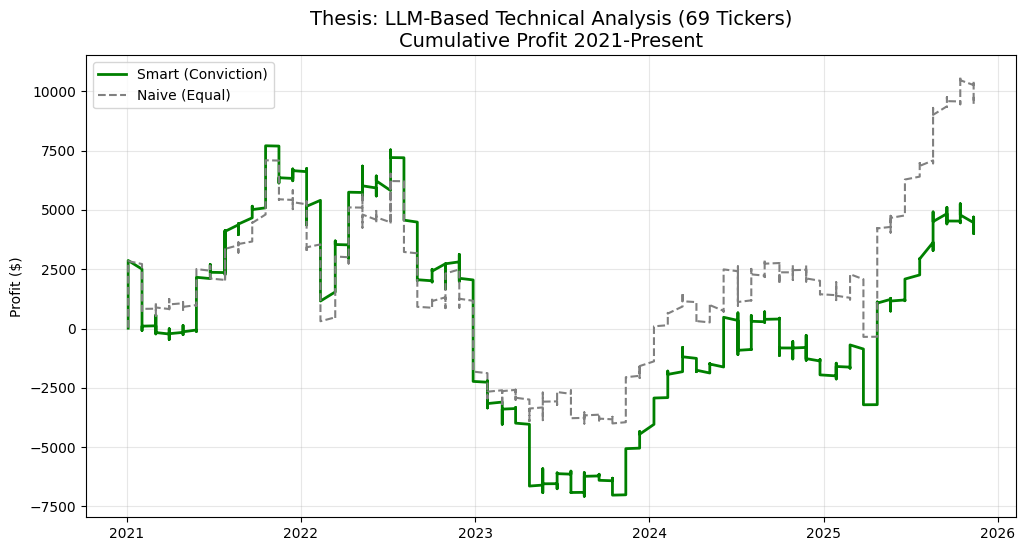

In [22]:
import matplotlib.pyplot as plt
import torch
from torch.nn import functional as F
import yfinance as yf
import numpy as np
import pandas as pd
import math
import time
from tqdm import tqdm  # Progress bar

# --- 1. CONFIGURATION ---

# 200+ Tickers across Regions & Sectors
ticker_map = {
    # INDICES & MACRO
    'SPY': 'Index_US', 'QQQ': 'Index_US', 'IWM': 'Index_US', 'DIA': 'Index_US',
    'EFA': 'Index_EU', 'EEM': 'Index_Emg', 'TLT': 'Bonds', 'GLD': 'Commodity', 'USO': 'Commodity',

    # US TECH
    'AAPL': 'US_Tech', 'MSFT': 'US_Tech', 'NVDA': 'US_Tech', 'GOOGL': 'US_Tech', 'AMZN': 'US_Tech',
    'META': 'US_Tech', 'TSLA': 'US_Tech', 'AMD': 'US_Tech', 'NFLX': 'US_Tech', 'INTC': 'US_Tech',
    'QCOM': 'US_Tech', 'AVGO': 'US_Tech', 'TXN': 'US_Tech', 'ADBE': 'US_Tech', 'CRM': 'US_Tech',
    'ORCL': 'US_Tech', 'CSCO': 'US_Tech', 'IBM': 'US_Tech', 'NOW': 'US_Tech', 'UBER': 'US_Tech',
    'ABNB': 'US_Tech', 'PLTR': 'US_Tech', 'SNOW': 'US_Tech', 'PANW': 'US_Tech', 'CRWD': 'US_Tech',
    'MU': 'US_Tech', 'LRCX': 'US_Tech', 'AMAT': 'US_Tech', 'ADI': 'US_Tech', 'KLAC': 'US_Tech',
    'SNPS': 'US_Tech', 'CDNS': 'US_Tech', 'MCHP': 'US_Tech', 'NXPI': 'US_Tech', 'MRVL': 'US_Tech',
    'FTNT': 'US_Tech', 'TEAM': 'US_Tech', 'DDOG': 'US_Tech', 'ZS': 'US_Tech', 'NET': 'US_Tech',
    
    """ add for final runs
    # US FINANCE
    'JPM': 'US_Fin', 'BAC': 'US_Fin', 'V': 'US_Fin', 'MA': 'US_Fin', 'GS': 'US_Fin',
    'MS': 'US_Fin', 'WFC': 'US_Fin', 'C': 'US_Fin', 'BLK': 'US_Fin', 'AXP': 'US_Fin',
    'COF': 'US_Fin', 'USB': 'US_Fin', 'PNC': 'US_Fin', 'SCHW': 'US_Fin', 'PYPL': 'US_Fin',
    'SPGI': 'US_Fin', 'MCO': 'US_Fin', 'CB': 'US_Fin', 'MMC': 'US_Fin', 'AON': 'US_Fin',
    'PGR': 'US_Fin', 'TRV': 'US_Fin', 'ALL': 'US_Fin', 'BK': 'US_Fin', 'STT': 'US_Fin',

    # US HEALTHCARE
    'JNJ': 'US_Health', 'PFE': 'US_Health', 'UNH': 'US_Health', 'LLY': 'US_Health', 'MRK': 'US_Health',
    'ABBV': 'US_Health', 'TMO': 'US_Health', 'DHR': 'US_Health', 'BMY': 'US_Health', 'AMGN': 'US_Health',
    'GILD': 'US_Health', 'CVS': 'US_Health', 'CI': 'US_Health', 'ISRG': 'US_Health', 'VRTX': 'US_Health',
    'REGN': 'US_Health', 'ZTS': 'US_Health', 'SYK': 'US_Health', 'BDX': 'US_Health', 'BSX': 'US_Health',
    'HUM': 'US_Health', 'ELV': 'US_Health', 'HCA': 'US_Health', 'MCK': 'US_Health', 'ABC': 'US_Health',

    # US CONSUMER & IND
    'WMT': 'US_Cons', 'KO': 'US_Cons', 'PEP': 'US_Cons', 'COST': 'US_Cons', 'MCD': 'US_Cons',
    'DIS': 'US_Cons', 'NKE': 'US_Cons', 'SBUX': 'US_Cons', 'TGT': 'US_Cons', 'HD': 'US_Cons',
    'LOW': 'US_Cons', 'PG': 'US_Cons', 'CL': 'US_Cons', 'MO': 'US_Cons', 'PM': 'US_Cons',
    'EL': 'US_Cons', 'LULU': 'US_Cons', 'CMG': 'US_Cons', 'MAR': 'US_Cons', 'BKNG': 'US_Cons',
    'BA': 'US_Ind', 'CAT': 'US_Ind', 'GE': 'US_Ind', 'HON': 'US_Ind', 'LMT': 'US_Ind',
    'RTX': 'US_Ind', 'UPS': 'US_Ind', 'FDX': 'US_Ind', 'DE': 'US_Ind', 'MMM': 'US_Ind',
    'F': 'US_Ind', 'GM': 'US_Ind', 'ETN': 'US_Ind', 'ITW': 'US_Ind', 'EMR': 'US_Ind',

    # US ENERGY & UTIL
    'XOM': 'US_Energy', 'CVX': 'US_Energy', 'COP': 'US_Energy', 'SLB': 'US_Energy', 'EOG': 'US_Energy',
    'OXY': 'US_Energy', 'MPC': 'US_Energy', 'VLO': 'US_Energy', 'NEE': 'US_Util', 'DUK': 'US_Util',
    'SO': 'US_Util', 'AEP': 'US_Util', 'D': 'US_Util', 'SRE': 'US_Util', 'PEG': 'US_Util',

    # EUROPE (ADRs)
    'ASML': 'EU', 'SAP': 'EU', 'NVO': 'EU', 'NVS': 'EU', 'AZN': 'EU', 'SHEL': 'EU',
    'TTE': 'EU', 'HSBC': 'EU', 'UL': 'EU', 'DEO': 'EU', 'BTI':EU', 'GSK': 'EU',
    'SNY': 'EU', 'ABB': 'EU', 'RELX': 'EU', 'NGG': 'EU', 'VOD': 'EU', 'ORAN': 'EU',
    'BP': 'EU', 'EQNR': 'EU', 'RACE': 'EU', 'STLA': 'EU', 'CNHI': 'EU', 'PUK': 'EU',
    """

    # ASIA (ADRs)
    'TSM': 'Asia', 'TM': 'Asia', 'SONY': 'Asia', 'HMC': 'Asia', 'MFG': 'Asia',
    'CAJ': 'Asia', 'TAK': 'Asia', 'NMR': 'Asia', 'IX': 'Asia', 'BABA': 'Asia',
    'JD': 'Asia', 'PDD': 'Asia', 'BIDU': 'Asia', 'TCOM': 'Asia', 'NIO': 'Asia',
    'INFY': 'Asia', 'HDB': 'Asia', 'IBN': 'Asia', 'WIT': 'Asia', 'MMYT': 'Asia'
}
tickers = list(ticker_map.keys())

num_simulations = 50
context_days = 60
prediction_days = 20
tokens_per_day = 4
block_size = 256
scale_factor = 100.0
total_price_days = context_days + prediction_days + 1
swing_threshold_pct = 2.0
start_date_backtest = "2021-01-01"

device = 'cuda' if torch.cuda.is_available() else 'cpu'
if 'model' in globals():
    model.eval()
    model.to(device)

print(f"Running on: {device.upper()}")

# --- 2. DATA FETCHING ---
print(f"Initializing Massive Backtest: {len(tickers)} Tickers from {start_date_backtest}")

# Chunk tickers to avoid API failures
chunk_size = 50
all_data = pd.DataFrame()

print("Step 1/3: Downloading market data...")
# Using tqdm for chunks
for i in tqdm(range(0, len(tickers), chunk_size), desc="Fetching Chunks"):
    chunk = tickers[i:i+chunk_size]
    try:
        # Buffer start date for context
        df_chunk = yf.download(chunk, start="2020-06-01", group_by='ticker', progress=False)
        all_data = pd.concat([all_data, df_chunk], axis=1)
        time.sleep(0.5) 
    except Exception as e:
        print(f"  Error fetching chunk {i}: {e}")

print(f"Data Download Complete. Shape: {all_data.shape}")

# --- 3. HELPER FUNCTIONS ---
def get_closest_token(value, itos_map):
    best_id = -1
    min_diff = float('inf')
    for token_id, token_val in itos_map.items():
        if not isinstance(token_val, (int, float)): continue
        diff = abs(value - token_val)
        if diff < min_diff:
            min_diff = diff
            best_id = token_id
    return best_id

def generate_simulation(model, idx, max_new_tokens, temperature=1.0, top_k=None):
    for _ in range(max_new_tokens):
        idx_cond = idx if idx.size(1) <= block_size else idx[:, -block_size:]
        logits, _ = model(idx_cond)
        logits = logits[:, -1, :] / temperature
        if top_k is not None:
            v, _ = torch.topk(logits, top_k)
            logits[logits < v[:, [-1]]] = -float('Inf')
        probs = F.softmax(logits, dim=-1)
        idx_next = torch.multinomial(probs, num_samples=1)
        idx = torch.cat((idx, idx_next), dim=1)
    return idx

# --- 4. PRE-PROCESSING (Build the Task List) ---
print("Step 2/3: Building Trade Queue...")

simulation_tasks = []

# Pre-scan data to find all valid trade setups
for ticker in tickers:
    if ticker not in all_data.columns.levels[0]:
        continue
        
    df = all_data[ticker].dropna().copy()
    if len(df) == 0: continue

    # Find start index
    try:
        start_idx_loc = df.index.searchsorted(pd.Timestamp(start_date_backtest))
    except:
        continue

    # Iterate through time in 20-day steps
    indices_to_test = range(start_idx_loc, len(df) - prediction_days, 20)

    for trade_idx in indices_to_test:
        ctx_start = trade_idx - context_days
        if ctx_start < 0: continue
        fut_end = trade_idx + prediction_days
        
        # We store the slice indices to avoid copying DF yet
        simulation_tasks.append({
            'ticker': ticker,
            'trade_idx': trade_idx,
            'ctx_start': ctx_start,
            'fut_end': fut_end
        })

print(f"Total Simulations to Run: {len(simulation_tasks)}")

# --- 5. EXECUTION LOOP ---
print("Step 3/3: Running Simulations on GPU...")
all_trades = []

# Use tqdm for the main loop
for task in tqdm(simulation_tasks, desc="Simulating"):
    ticker = task['ticker']
    trade_idx = task['trade_idx']
    ctx_start = task['ctx_start']
    fut_end = task['fut_end']
    
    try:
        df = all_data[ticker].dropna() # Access cached data
        df_window = df.iloc[ctx_start : fut_end + 1].copy()
        
        # Tokenize
        tokens = []
        valid_window = True
        
        for i in range(1, context_days + 1):
            prev_close = float(df_window['Close'].iloc[i-1])
            curr_open  = float(df_window['Open'].iloc[i])
            curr_high  = float(df_window['High'].iloc[i])
            curr_low   = float(df_window['Low'].iloc[i])
            curr_close = float(df_window['Close'].iloc[i])
            
            if prev_close <= 0 or curr_open <= 0: 
                valid_window = False; break

            val_open   = math.log(curr_open / prev_close) * scale_factor
            val_high   = math.log(curr_high / curr_open) * scale_factor
            val_low    = math.log(curr_low / curr_open) * scale_factor
            val_close  = math.log(curr_close / curr_open) * scale_factor

            tokens.extend([
                get_closest_token(val_open, itos), get_closest_token(val_high, itos),
                get_closest_token(val_low, itos), get_closest_token(val_close, itos)
            ])
        
        if not valid_window: continue

        tensor_seq = torch.tensor(tokens, dtype=torch.long).unsqueeze(0).to(device)
        if tensor_seq.size(1) > block_size: tensor_seq = tensor_seq[:, -block_size:]

        # Run Model (GPU)
        batch_input = tensor_seq.repeat(num_simulations, 1)
        with torch.no_grad():
            generated = generate_simulation(
                model, batch_input, max_new_tokens=prediction_days * tokens_per_day,
                temperature=0.7, top_k=40
            )

        # Decode
        future_tokens = generated[:, -prediction_days * tokens_per_day:].cpu()
        future_tokens = future_tokens.view(num_simulations, prediction_days, 4)
        open_tokens = future_tokens[:, :, 0]
        close_tokens = future_tokens[:, :, 3]

        sim_returns_pct = []
        for sim in range(num_simulations):
            log_ret = 0.0
            for t in range(prediction_days):
                v_open = itos.get(open_tokens[sim, t].item(), 0.0) / scale_factor
                v_close = itos.get(close_tokens[sim, t].item(), 0.0) / scale_factor
                log_ret += (v_open + v_close)
            sim_returns_pct.append((math.exp(log_ret) - 1.0) * 100.0)

        # Metrics
        arr_returns = np.array(sim_returns_pct)
        pred_return = np.median(arr_returns)
        pred_risk   = np.std(arr_returns) + 1e-6
        conviction = pred_return / pred_risk

        entry_price = float(df_window['Close'].iloc[context_days])
        exit_price  = float(df_window['Close'].iloc[-1])
        actual_return = (exit_price - entry_price) / entry_price * 100.0
        
        trade_date = df_window.index[context_days]

        all_trades.append({
            'date': trade_date,
            'year': trade_date.year,
            'ticker': ticker,
            'region': ticker_map.get(ticker, 'Other'),
            'pred_return': pred_return,
            'conviction': conviction,
            'actual_return': actual_return
        })

    except Exception as e:
        continue

# --- 6. REPORTING ---
df = pd.DataFrame(all_trades)

if len(df) > 0:
    # Filter Signals
    df_signals = df[abs(df['pred_return']) >= swing_threshold_pct].copy()
    
    # Calculate PnL
    df_signals['naive_pnl'] = 1000 * np.sign(df_signals['pred_return']) * df_signals['actual_return'] / 100
    df_signals['smart_bet'] = 1000 * df_signals['conviction'].apply(lambda x: min(abs(x), 3.0)) * np.sign(df_signals['pred_return'])
    df_signals['smart_pnl'] = df_signals['smart_bet'] * df_signals['actual_return'] / 100
    df_signals['win'] = np.sign(df_signals['pred_return']) == np.sign(df_signals['actual_return'])

    print("\n" + "="*50)
    print(f"GLOBAL RESULTS (2021-Present) | N={len(df_signals)} Trades")
    print("="*50)
    print(f"Total Smart PnL:   ${df_signals['smart_pnl'].sum():,.2f}")
    print(f"Total Naive PnL:   ${df_signals['naive_pnl'].sum():,.2f}")
    print(f"Global Win Rate:   {df_signals['win'].mean()*100:.1f}%")

    print("\n--- By Year ---")
    print(df_signals.groupby('year').agg({'smart_pnl':'sum', 'naive_pnl':'sum', 'win':'mean', 'ticker':'count'}).round(2))
    
    print("\n--- By Region / Sector ---")
    print(df_signals.groupby('region').agg({'smart_pnl':'sum', 'naive_pnl':'sum', 'win':'mean', 'ticker':'count'}).round(2))

    # Plot
    df_signals = df_signals.sort_values('date')
    df_signals['cumsum_smart'] = df_signals['smart_pnl'].cumsum()
    df_signals['cumsum_naive'] = df_signals['naive_pnl'].cumsum()

    plt.figure(figsize=(12, 6))
    plt.plot(df_signals['date'], df_signals['cumsum_smart'], label='Smart (Conviction)', color='green', linewidth=2)
    plt.plot(df_signals['date'], df_signals['cumsum_naive'], label='Naive (Equal)', linestyle='--', color='gray')
    plt.title(f"Thesis: LLM-Based Technical Analysis ({len(tickers)} Tickers)\nCumulative Profit 2021-Present", fontsize=14)
    plt.ylabel("Profit ($)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig('thesis_supercomputer_results.png', dpi=300, bbox_inches='tight')
    plt.show()

else:
    print("No trades generated.")

In [23]:
import matplotlib.pyplot as plt
import torch
from torch.nn import functional as F
import yfinance as yf
import numpy as np
import pandas as pd
import math
import time
from tqdm import tqdm

# --- 1. CONFIGURATION ---

# Ticker Map based on your snippet (Active keys only)
ticker_map = {
    # INDICES & MACRO
    'SPY': 'Index_US', 'QQQ': 'Index_US', 'IWM': 'Index_US', 'DIA': 'Index_US',
    'EFA': 'Index_EU', 'EEM': 'Index_Emg', 'TLT': 'Bonds', 'GLD': 'Commodity', 'USO': 'Commodity',

    # US TECH
    'AAPL': 'US_Tech', 'MSFT': 'US_Tech', 'NVDA': 'US_Tech', 'GOOGL': 'US_Tech', 'AMZN': 'US_Tech',
    'META': 'US_Tech', 'TSLA': 'US_Tech', 'AMD': 'US_Tech', 'NFLX': 'US_Tech', 'INTC': 'US_Tech',
    'QCOM': 'US_Tech', 'AVGO': 'US_Tech', 'TXN': 'US_Tech', 'ADBE': 'US_Tech', 'CRM': 'US_Tech',
    'ORCL': 'US_Tech', 'CSCO': 'US_Tech', 'IBM': 'US_Tech', 'NOW': 'US_Tech', 'UBER': 'US_Tech',
    'ABNB': 'US_Tech', 'PLTR': 'US_Tech', 'SNOW': 'US_Tech', 'PANW': 'US_Tech', 'CRWD': 'US_Tech',
    'MU': 'US_Tech', 'LRCX': 'US_Tech', 'AMAT': 'US_Tech', 'ADI': 'US_Tech', 'KLAC': 'US_Tech',
    'SNPS': 'US_Tech', 'CDNS': 'US_Tech', 'MCHP': 'US_Tech', 'NXPI': 'US_Tech', 'MRVL': 'US_Tech',
    'FTNT': 'US_Tech', 'TEAM': 'US_Tech', 'DDOG': 'US_Tech', 'ZS': 'US_Tech', 'NET': 'US_Tech',

    # ASIA (ADRs)
    'TSM': 'Asia', 'TM': 'Asia', 'SONY': 'Asia', 'HMC': 'Asia', 'MFG': 'Asia',
    'CAJ': 'Asia', 'TAK': 'Asia', 'NMR': 'Asia', 'IX': 'Asia', 'BABA': 'Asia',
    'JD': 'Asia', 'PDD': 'Asia', 'BIDU': 'Asia', 'TCOM': 'Asia', 'NIO': 'Asia',
    'INFY': 'Asia', 'HDB': 'Asia', 'IBN': 'Asia', 'WIT': 'Asia', 'MMYT': 'Asia'
}
tickers = list(ticker_map.keys())

num_simulations = 50
context_days = 60
prediction_days = 20
tokens_per_day = 4
block_size = 256
scale_factor = 100.0
total_price_days = context_days + prediction_days + 1
swing_threshold_pct = 2.0
start_date_backtest = "2021-01-01"

device = 'cuda' if torch.cuda.is_available() else 'cpu'
if 'model' in globals():
    model.eval()
    model.to(device)

print(f"Running on: {device.upper()}")

# --- 2. DATA FETCHING ---
print(f"Initializing Hypothesis Tests: {len(tickers)} Tickers from {start_date_backtest}")

chunk_size = 50
all_data = pd.DataFrame()

print("Step 1/4: Downloading market data...")
for i in tqdm(range(0, len(tickers), chunk_size), desc="Fetching Chunks"):
    chunk = tickers[i:i+chunk_size]
    try:
        # Buffer start date
        df_chunk = yf.download(chunk, start="2020-06-01", group_by='ticker', progress=False)
        all_data = pd.concat([all_data, df_chunk], axis=1)
        time.sleep(0.5) 
    except Exception as e:
        print(f"  Error fetching chunk {i}: {e}")

# --- 3. HELPER FUNCTIONS ---
def get_closest_token(value, itos_map):
    best_id = -1
    min_diff = float('inf')
    for token_id, token_val in itos_map.items():
        if not isinstance(token_val, (int, float)): continue
        diff = abs(value - token_val)
        if diff < min_diff:
            min_diff = diff
            best_id = token_id
    return best_id

def generate_simulation(model, idx, max_new_tokens, temperature=1.0, top_k=None):
    for _ in range(max_new_tokens):
        idx_cond = idx if idx.size(1) <= block_size else idx[:, -block_size:]
        logits, _ = model(idx_cond)
        logits = logits[:, -1, :] / temperature
        if top_k is not None:
            v, _ = torch.topk(logits, top_k)
            logits[logits < v[:, [-1]]] = -float('Inf')
        probs = F.softmax(logits, dim=-1)
        idx_next = torch.multinomial(probs, num_samples=1)
        idx = torch.cat((idx, idx_next), dim=1)
    return idx

# --- 4. PRE-PROCESSING ---
print("Step 2/4: Building Trade Queue...")
simulation_tasks = []

for ticker in tickers:
    if ticker not in all_data.columns.levels[0]: continue
        
    df = all_data[ticker].dropna().copy()
    if len(df) == 0: continue

    try:
        start_idx_loc = df.index.searchsorted(pd.Timestamp(start_date_backtest))
    except:
        continue

    # Step 20 days
    indices_to_test = range(start_idx_loc, len(df) - prediction_days, 20)

    for trade_idx in indices_to_test:
        ctx_start = trade_idx - context_days
        if ctx_start < 0: continue
        fut_end = trade_idx + prediction_days
        
        simulation_tasks.append({
            'ticker': ticker,
            'trade_idx': trade_idx,
            'ctx_start': ctx_start,
            'fut_end': fut_end
        })

# --- 5. EXECUTION LOOP ---
print(f"Step 3/4: Running {len(simulation_tasks)} Simulations...")
all_trades = []

for task in tqdm(simulation_tasks, desc="Simulating"):
    ticker = task['ticker']
    trade_idx = task['trade_idx']
    ctx_start = task['ctx_start']
    fut_end = task['fut_end']
    
    try:
        df = all_data[ticker].dropna()
        df_window = df.iloc[ctx_start : fut_end + 1].copy()
        
        tokens = []
        valid_window = True
        
        for i in range(1, context_days + 1):
            prev_close = float(df_window['Close'].iloc[i-1])
            curr_open  = float(df_window['Open'].iloc[i])
            # ... (Simple checks)
            if prev_close <= 0 or curr_open <= 0: 
                valid_window = False; break

            # Log returns
            val_open   = math.log(curr_open / prev_close) * scale_factor
            val_high   = math.log(float(df_window['High'].iloc[i]) / curr_open) * scale_factor
            val_low    = math.log(float(df_window['Low'].iloc[i]) / curr_open) * scale_factor
            val_close  = math.log(float(df_window['Close'].iloc[i]) / curr_open) * scale_factor

            tokens.extend([
                get_closest_token(val_open, itos), get_closest_token(val_high, itos),
                get_closest_token(val_low, itos), get_closest_token(val_close, itos)
            ])
        
        if not valid_window: continue

        tensor_seq = torch.tensor(tokens, dtype=torch.long).unsqueeze(0).to(device)
        if tensor_seq.size(1) > block_size: tensor_seq = tensor_seq[:, -block_size:]

        # GPU Gen
        batch_input = tensor_seq.repeat(num_simulations, 1)
        with torch.no_grad():
            generated = generate_simulation(
                model, batch_input, max_new_tokens=prediction_days * tokens_per_day,
                temperature=0.7, top_k=40
            )

        # Decode
        future_tokens = generated[:, -prediction_days * tokens_per_day:].cpu()
        future_tokens = future_tokens.view(num_simulations, prediction_days, 4)
        open_tokens = future_tokens[:, :, 0]
        close_tokens = future_tokens[:, :, 3]

        sim_returns_pct = []
        for sim in range(num_simulations):
            log_ret = 0.0
            for t in range(prediction_days):
                v_open = itos.get(open_tokens[sim, t].item(), 0.0) / scale_factor
                v_close = itos.get(close_tokens[sim, t].item(), 0.0) / scale_factor
                log_ret += (v_open + v_close)
            sim_returns_pct.append((math.exp(log_ret) - 1.0) * 100.0)

        # Metrics
        arr_returns = np.array(sim_returns_pct)
        pred_return = np.median(arr_returns)
        pred_risk   = np.std(arr_returns) + 1e-6
        conviction = pred_return / pred_risk

        entry_price = float(df_window['Close'].iloc[context_days])
        exit_price  = float(df_window['Close'].iloc[-1])
        actual_return = (exit_price - entry_price) / entry_price * 100.0
        
        trade_date = df_window.index[context_days]

        all_trades.append({
            'date': trade_date,
            'year': trade_date.year,
            'ticker': ticker,
            'region': ticker_map.get(ticker, 'Other'),
            'pred_return': pred_return,
            'conviction': conviction,
            'actual_return': actual_return
        })

    except Exception as e:
        continue

# --- 6. NUMERICAL HYPOTHESIS TESTING ---
print("\n" + "="*50)
print("Step 4/4: NUMERICAL HYPOTHESIS TESTING")
print("="*50)

df = pd.DataFrame(all_trades)
if len(df) == 0:
    print("No trades generated.")
else:
    # Filter for Signals
    df_signals = df[abs(df['pred_return']) >= swing_threshold_pct].copy()
    
    # Calculate PnL Vectors
    df_signals['naive_pnl'] = 1000 * np.sign(df_signals['pred_return']) * df_signals['actual_return'] / 100
    # Smart Bet: Capped at 3x leverage
    df_signals['smart_bet'] = 1000 * df_signals['conviction'].apply(lambda x: min(abs(x), 3.0)) * np.sign(df_signals['pred_return'])
    df_signals['smart_pnl'] = df_signals['smart_bet'] * df_signals['actual_return'] / 100
    df_signals['win'] = np.sign(df_signals['pred_return']) == np.sign(df_signals['actual_return'])

    # --- TEST 1: REGIME DEPENDENCY (H1) ---
    print("\n--- H1: REGIME DEPENDENCY (Bull vs Bear) ---")
    print("Hypothesis: Smart Strategy outperforms in Bull markets (2021, 2024) but fails in Bear (2022).")
    
    # Define Regimes manually for clarity
    bull_years = [2021, 2024, 2025]
    bear_years = [2022]
    
    h1_stats = df_signals.groupby('year').agg({
        'smart_pnl': 'sum',
        'naive_pnl': 'sum',
        'win': 'mean'
    }).rename(columns={'win': 'win_rate'})
    h1_stats['win_rate'] = (h1_stats['win_rate'] * 100).round(1)
    
    # Calculate "Alpha" (Smart - Naive)
    h1_stats['alpha_dollar'] = h1_stats['smart_pnl'] - h1_stats['naive_pnl']
    print(h1_stats[['smart_pnl', 'naive_pnl', 'alpha_dollar', 'win_rate']])

    # --- TEST 2: MACRO VS MICRO (H2) ---
    print("\n--- H2: MACRO VS MICRO (Indices vs Tech) ---")
    print("Hypothesis: Model finds more consistent Alpha in Indices/Commodities than Idiosyncratic Tech.")
    
    # Create broad categories
    def classify_asset(region):
        if 'Index' in region or 'Commodity' in region or 'Bonds' in region:
            return 'Macro_Asset'
        elif 'Tech' in region:
            return 'Single_Stock_Tech'
        else:
            return 'Other_Stock'
            
    df_signals['asset_class'] = df_signals['region'].apply(classify_asset)
    
    h2_stats = df_signals.groupby('asset_class').agg({
        'smart_pnl': 'sum',
        'naive_pnl': 'sum',
        'win': 'mean',
        'smart_bet': 'count' # Number of trades
    }).rename(columns={'win': 'win_rate', 'smart_bet': 'trade_count'})
    h2_stats['win_rate'] = (h2_stats['win_rate'] * 100).round(1)
    
    # Per-trade average profitability
    h2_stats['avg_profit_per_trade'] = (h2_stats['smart_pnl'] / h2_stats['trade_count']).round(2)
    print(h2_stats[['trade_count', 'win_rate', 'smart_pnl', 'avg_profit_per_trade']])

    # --- TEST 3: THE "CONVICTION TRAP" (H3) ---
    print("\n--- H3: THE 2022 CONVICTION TRAP ---")
    print("Hypothesis: In 2022, High Conviction bets (> 1.5 score) lost more money than Low Conviction bets.")
    
    df_2022 = df_signals[df_signals['year'] == 2022].copy()
    
    if len(df_2022) > 0:
        # Split into High vs Low Conviction
        high_conv = df_2022[abs(df_2022['conviction']) >= 1.5]
        low_conv  = df_2022[abs(df_2022['conviction']) < 1.5]
        
        avg_loss_high = high_conv['smart_pnl'].mean()
        avg_loss_low  = low_conv['smart_pnl'].mean()
        
        print(f"2022 Stats (Bear Market):")
        print(f"  High Conviction Trades (N={len(high_conv)}): Avg PnL ${avg_loss_high:.2f}")
        print(f"  Low Conviction Trades  (N={len(low_conv)}): Avg PnL ${avg_loss_low:.2f}")
        
        if avg_loss_high < avg_loss_low:
            print("  -> RESULT: CONFIRMED. High conviction led to deeper losses.")
        else:
            print("  -> RESULT: REJECTED. High conviction protected capital.")
    else:
        print("  No trades in 2022 to analyze.")

Running on: CUDA
Initializing Hypothesis Tests: 69 Tickers from 2021-01-01
Step 1/4: Downloading market data...


Fetching Chunks:  50%|█████     | 1/2 [00:07<00:07,  7.44s/it]$CAJ: possibly delisted; no timezone found

1 Failed download:
['CAJ']: possibly delisted; no timezone found
Fetching Chunks: 100%|██████████| 2/2 [00:08<00:00,  4.35s/it]


Step 2/4: Building Trade Queue...
Step 3/4: Running 4213 Simulations...


Simulating: 100%|██████████| 4213/4213 [3:29:50<00:00,  2.99s/it]  


Step 4/4: NUMERICAL HYPOTHESIS TESTING

--- H1: REGIME DEPENDENCY (Bull vs Bear) ---
Hypothesis: Smart Strategy outperforms in Bull markets (2021, 2024) but fails in Bear (2022).
        smart_pnl    naive_pnl  alpha_dollar  win_rate
year                                                  
2021  5913.005956  5424.233530    488.772426      54.7
2022 -8974.908094 -6658.525177  -2316.382917      44.7
2023 -3117.045969  -254.973388  -2862.072581      53.6
2024  3211.140516  3687.540413   -476.399897      52.4
2025  6622.748277  8346.811065  -1724.062788      55.8

--- H2: MACRO VS MICRO (Indices vs Tech) ---
Hypothesis: Model finds more consistent Alpha in Indices/Commodities than Idiosyncratic Tech.
                   trade_count  win_rate    smart_pnl  avg_profit_per_trade
asset_class                                                                
Macro_Asset                117      56.4  1531.754077                 13.09
Other_Stock                498      49.6   597.701459              